# Human Cell Lines: single cell PCHA

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from py_pcha import PCHA
from sklearn.utils import shuffle
from matplotlib.colors import CenteredNorm

In [3]:
adata = sc.read_h5ad('../../out/cell-lines/adata_01.h5ad')

## MAGIC

In [4]:
import magic
# import pandas as pd
# import matplotlib.pyplot as plt
magic_operator = magic.MAGIC(solver='approximate')
X_magic = magic_operator.fit_transform(adata)


Calculating MAGIC...
  Running MAGIC on 16108 cells and 20446 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.59 seconds.
    Calculating KNN search...
    Calculated KNN search in 34.56 seconds.
    Calculating affinities...
    Calculated affinities in 31.02 seconds.
  Calculated graph and diffusion operator in 75.21 seconds.
  Calculating imputation...
  Calculated imputation in 0.07 seconds.
Calculated MAGIC in 80.05 seconds.


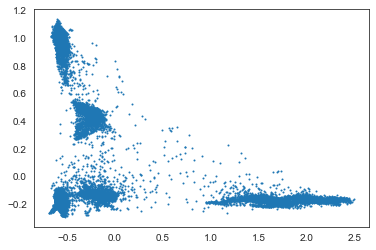

In [5]:
plt.scatter(X_magic.obs_vector('ASCL1'), X_magic.obs_vector('NEUROD2'),  s=1, cmap='inferno')


In [6]:
sc.pp.pca(X_magic)

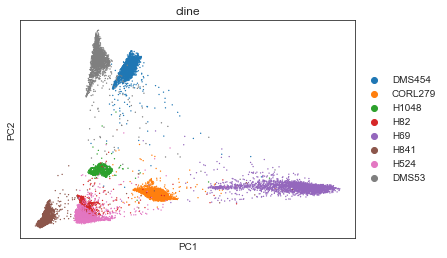

In [7]:
sc.pl.pca(X_magic, color='cline')

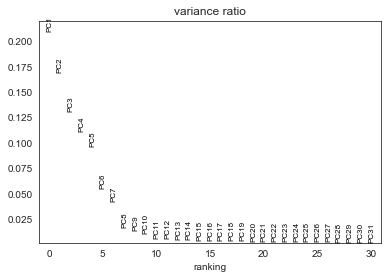

In [8]:
sc.pl.pca_variance_ratio(X_magic)

In [9]:
pca_var = X_magic.uns['pca']['variance_ratio']
var_explained = .85
tot_exp_var = 0
n = 0
for i in pca_var:
    n +=1
    tot_exp_var += i
    if tot_exp_var > var_explained: 
        print(n+1, "PCs explain at least", var_explained*100, "percent of the variance")
        break

11 PCs explain at least 85.0 percent of the variance


In [10]:
def cumulative(var):
    cum_var = []
    tot_sum = 0
    for i in var:
        tot_sum += i
        cum_var.append(tot_sum)
    return cum_var


In [12]:
cum_var = cumulative(pca_var)
cum_var[7]

0.8333993833512068

In [14]:
def find_knee_varexpl(cum_var):
    farthestk = 0
    for i in range(50):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([0,cum_var[0]])
        p2=np.array([49,cum_var[49]])
        p3=np.array([i,cum_var[i]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    return knee +1 # number of components is 1 more than index
print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

Knee of EV vs PC plot:  7


In [14]:
X_magic.write_h5ad('../../out/cell-lines/X_magic_02.h5ad')

# PCHA on MAGIC imputed data

In [147]:
!pip install py_pcha

In [14]:
X_magic = sc.read_h5ad('../../out/cell-lines/X_magic_02.h5ad')

In [329]:
def find_knee(ev_per_arc, kmax):
    farthestk = 0
    for i in range(3,kmax):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([3,ev_per_arc[0]])
        p2=np.array([kmax,ev_per_arc[kmax-3]])
        p3=np.array([i,ev_per_arc[i-3]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    print("K* =",knee, "archetypes, distance between k* and line: ",np.round(farthestk,2))
    return knee, farthestk

## Full PCA with 50 components
Running PCHA on the full PCA (50 components)-- the variance explained here is the proportion of the variance in the full 50 components.

0
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 5 archetypes, distance between k* and line:  0.08
k_max = 9
K* = 5 archetypes, distance between k* and line:  0.09
k_max = 10
K* = 5 archetypes, distance between k* and line:  0.11


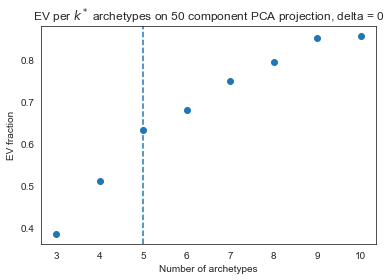

0.1
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 5 archetypes, distance between k* and line:  0.08
k_max = 9
K* = 5 archetypes, distance between k* and line:  0.09
k_max = 10
K* = 7 archetypes, distance between k* and line:  0.12


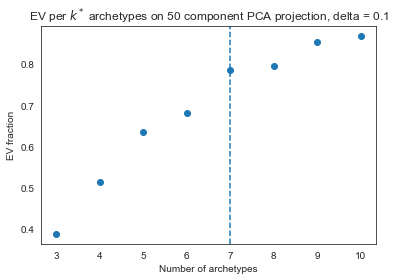

0.2
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 5 archetypes, distance between k* and line:  0.07
k_max = 9
K* = 5 archetypes, distance between k* and line:  0.09
k_max = 10
K* = 7 archetypes, distance between k* and line:  0.12


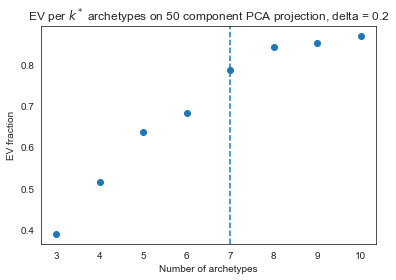

0.5
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 6 archetypes, distance between k* and line:  0.08
k_max = 9
K* = 6 archetypes, distance between k* and line:  0.12
k_max = 10
K* = 6 archetypes, distance between k* and line:  0.14


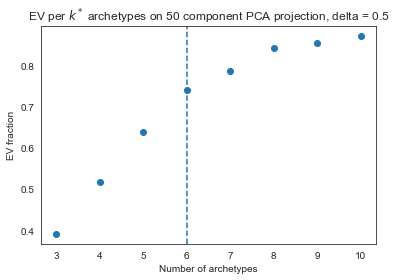

1
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 6 archetypes, distance between k* and line:  0.08
k_max = 9
K* = 6 archetypes, distance between k* and line:  0.12
k_max = 10
K* = 6 archetypes, distance between k* and line:  0.14


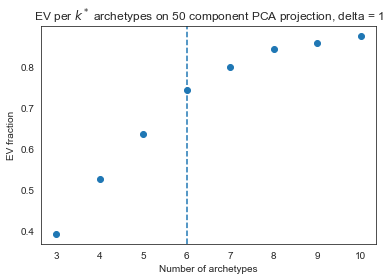

In [18]:
def ev_per_arc_by_delta_50comp(delta):
    ev_per_arc = []
    for i in range(3,11):
        XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'].T, noc=i, delta=delta)
        ev_per_arc.append(varexpl)
        # print(varexpl)
    plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
    plt.title(f"EV per $k^*$ archetypes on 50 component PCA projection, delta = {delta}")
    plt.xlabel("Number of archetypes")
    plt.ylabel("EV fraction")
    print("Knee in EV vs k plot for different k_max:")
    for kmax in range(8,11):
        print('k_max =', kmax)
        knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
    plt.axvline(x=knee, linestyle = "--")
    plt.savefig(f'../../figures/EV_per_k_50comp_clines_delta_{delta}.pdf')
    plt.show()
for delta in [0,0.1,0.2,0.5,1]:
    print(delta)
    ev_per_arc_by_delta_50comp(delta)

### Three archetypes

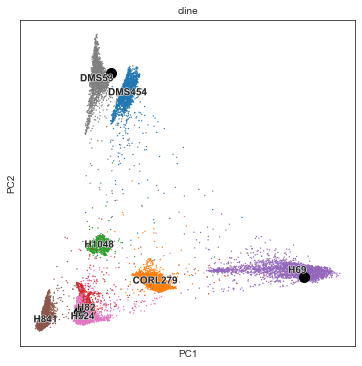

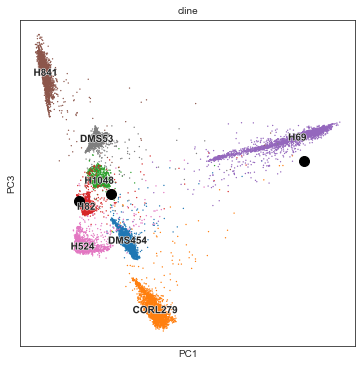

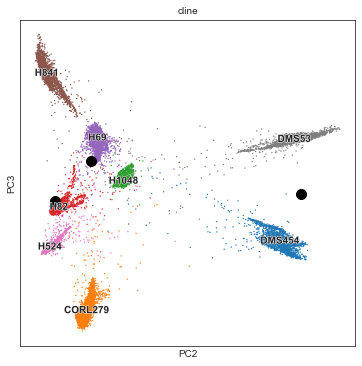

In [23]:
XC_3_50comp, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'].T, noc=3, delta=0.1)
XC_3_50comp = np.array(XC_3_50comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'cline', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_3_50comp[int(comp[0])-1], XC_3_50comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

### Five archetypes

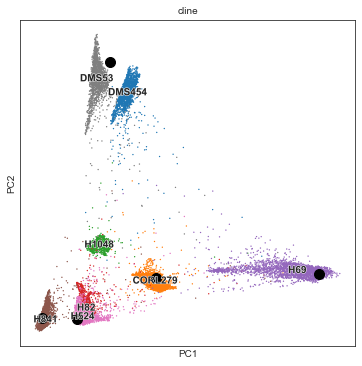

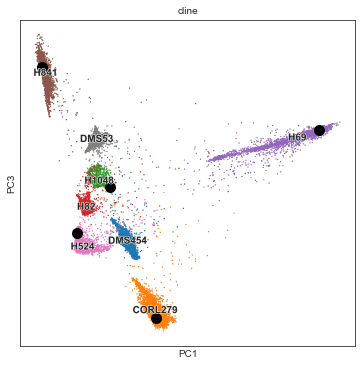

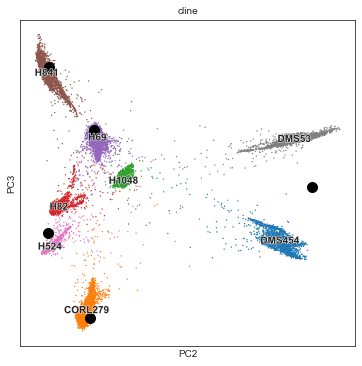

In [19]:
XC_5_50comp, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'].T, noc=5, delta=0.1)
XC_5_50comp = np.array(XC_5_50comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'cline', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_5_50comp[int(comp[0])-1], XC_5_50comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

### Six archetypes

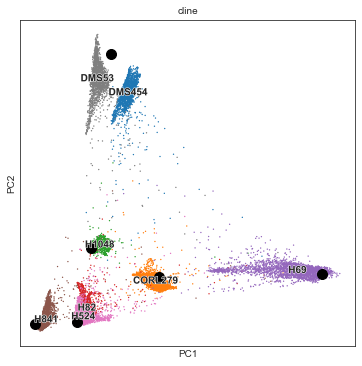

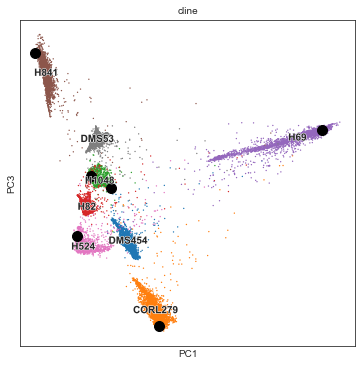

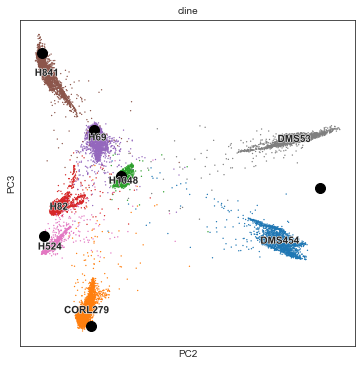

In [20]:
XC_6_50comp, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'].T, noc=6, delta=0.1)
XC_6_50comp = np.array(XC_6_50comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'cline', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_6_50comp[int(comp[0])-1], XC_6_50comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

### Seven archetypes

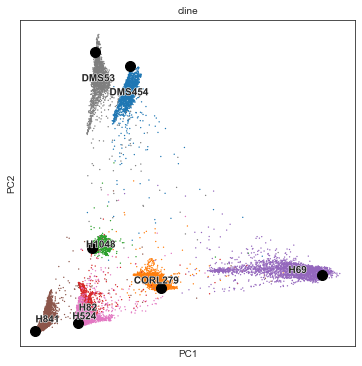

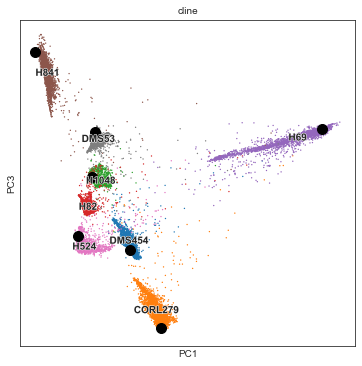

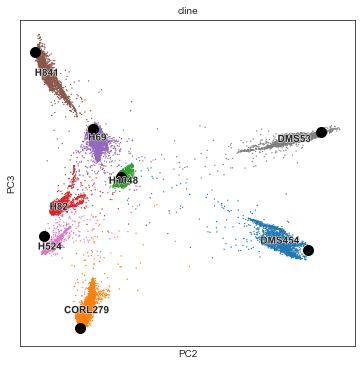

In [21]:
XC_7_50comp, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'].T, noc=7, delta=0.1)
XC_7_50comp = np.array(XC_7_50comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'cline', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_7_50comp[int(comp[0])-1], XC_7_50comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

**Conclusions**
When we run a PCA on the magic imputed dataset, over 80% of the variance in explained by just the first 8 components (most likely due to the fact that we have 8 samples). PCHA in the full PCA space (50 components) shows that 5 or 7 archetypes best describe the data. With five archetypes, we get archetypes near H841 (Y), H524 (N), DMS454/53 (A2), H69 (A), and CORL279 (A/N). H1048 and H82 are closer to the middle. We can use the method described in the MAGIC paper to assign archetypal neighborhoods.
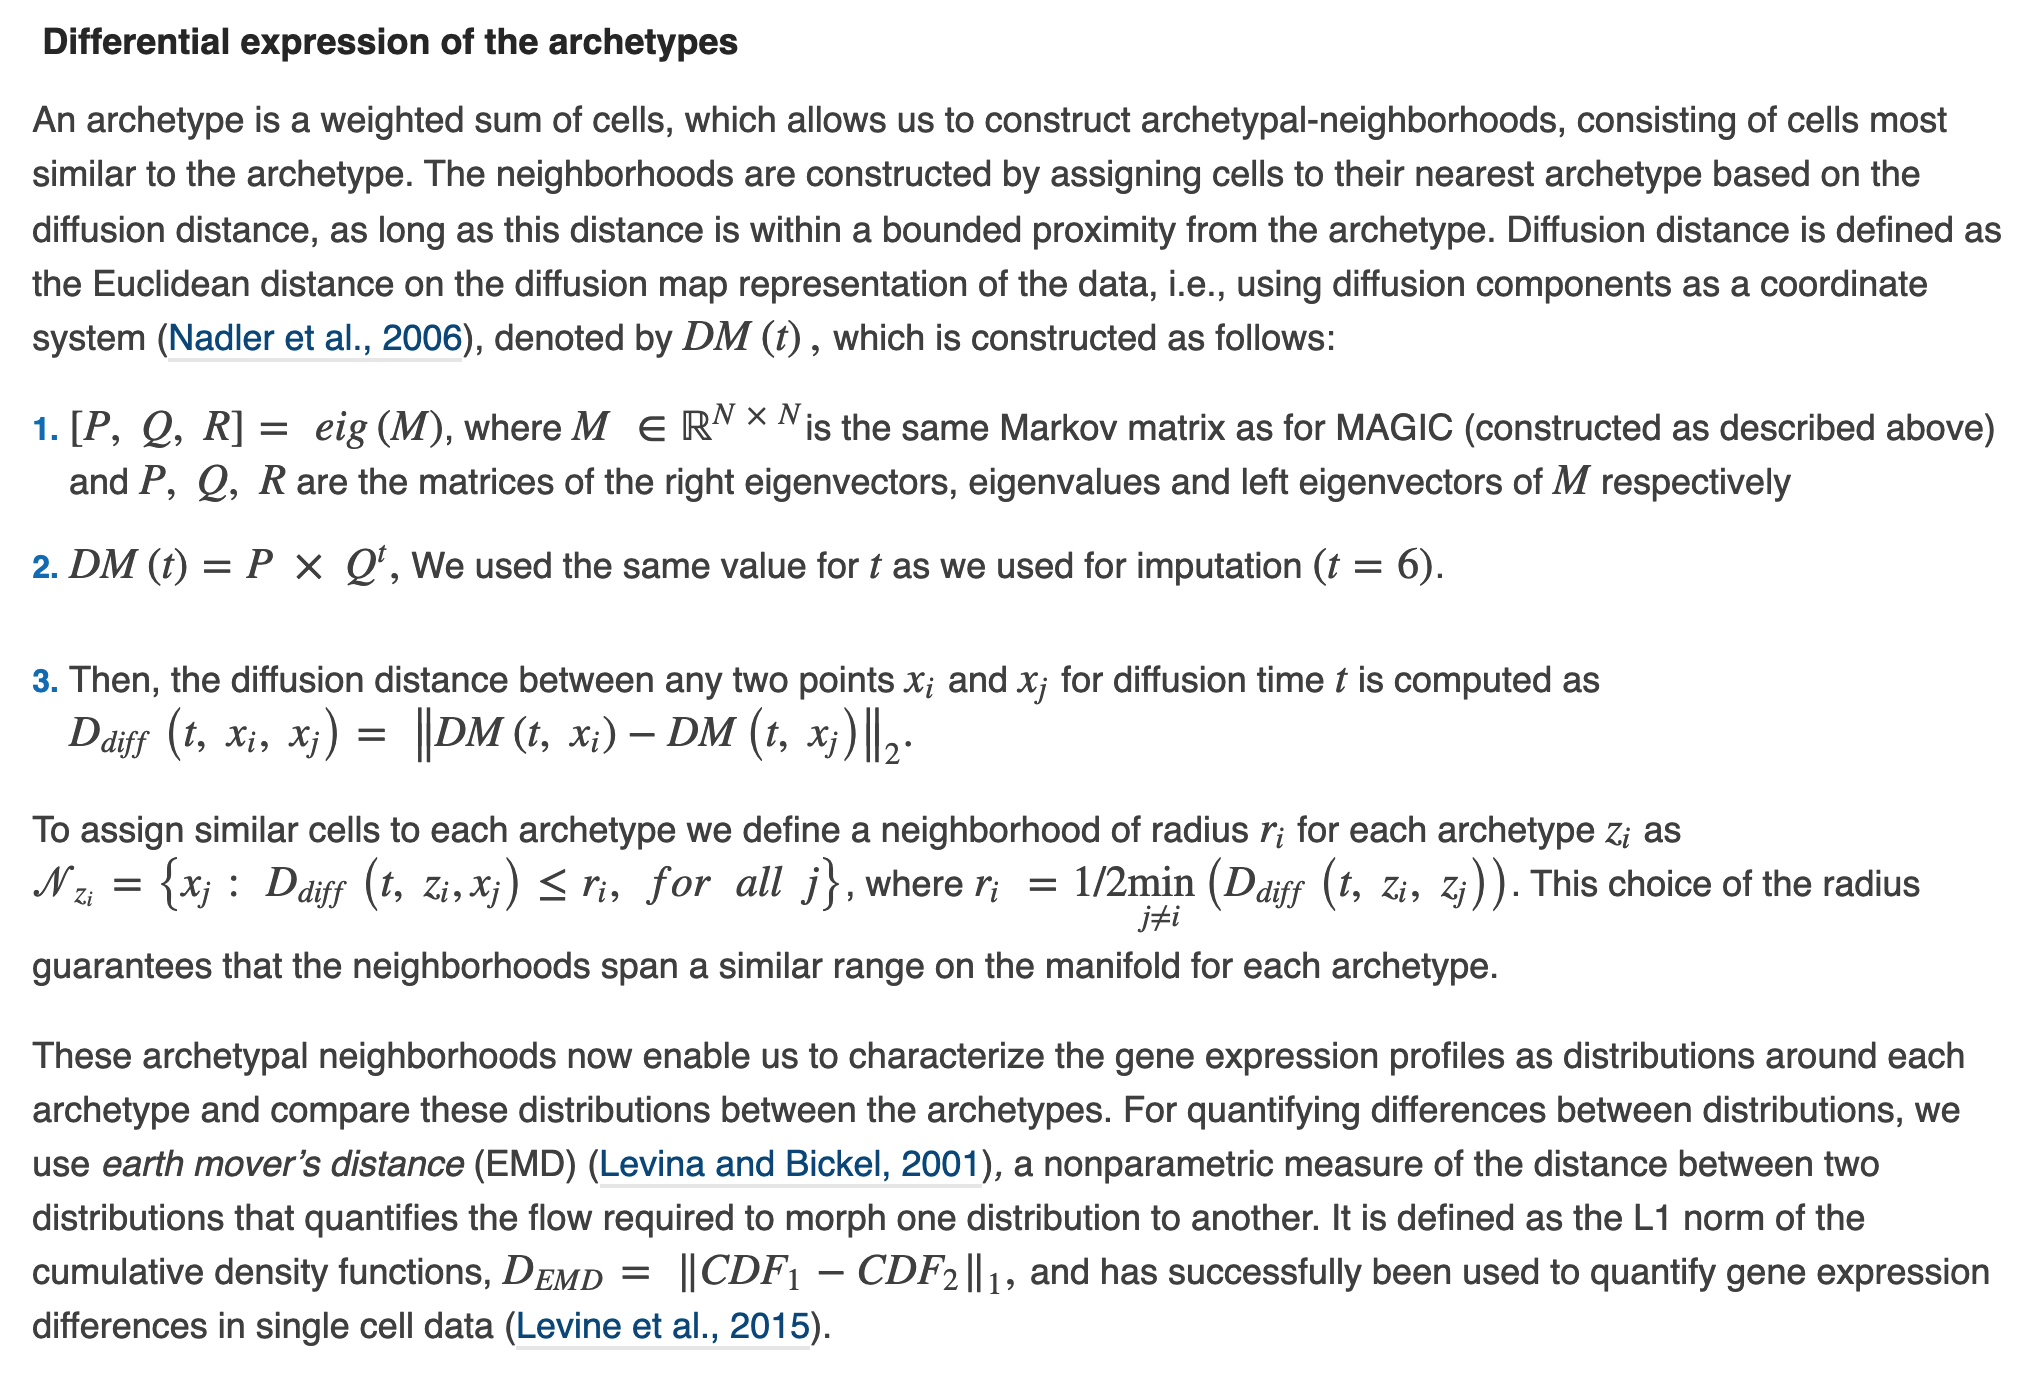

## Top 8 components of PCA
The top 8 components explain over 81% of the imputed data (and form the elbow of the EV vs PC curve), so we can double check that we get the same results when subsetting to these components. This shouldn't make much difference, but it will make a difference in the distances of cells to archetypes, since volume increases exponentially. The number of data points needed to robustly approximate the polytope also grows exponentially with the dimension.

Knee in EV vs k plot for different k_max:
k_max = 8
K* = 6 archetypes, distance between k* and line:  0.09
k_max = 9
K* = 6 archetypes, distance between k* and line:  0.14
k_max = 10
K* = 6 archetypes, distance between k* and line:  0.17


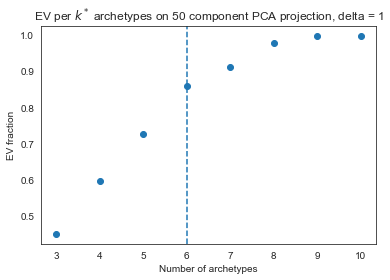

In [25]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:8].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    # print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 50 component PCA projection, delta = {delta}")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.savefig(f'../../figures/EV_per_k_8comp_clines_delta_0.1.pdf')
plt.show()

**It looks like 6 archetypes still fit the data well.** We'll calculate the archetype locations in the top 8 dimensions, and then use the PC coefficient matrix to estimate the archetypes on the original phenotypic space.

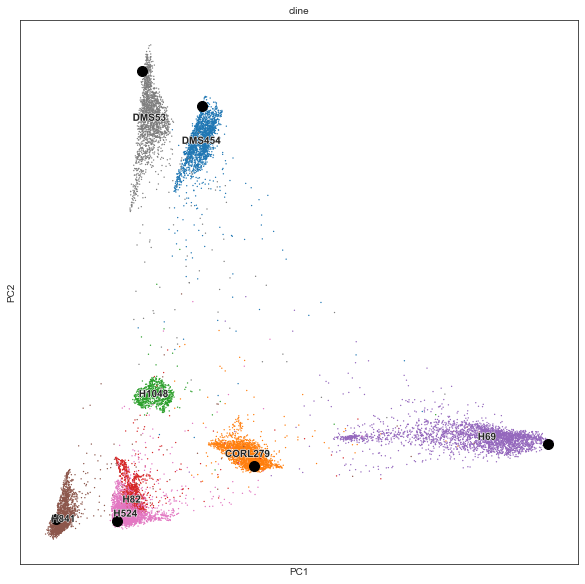

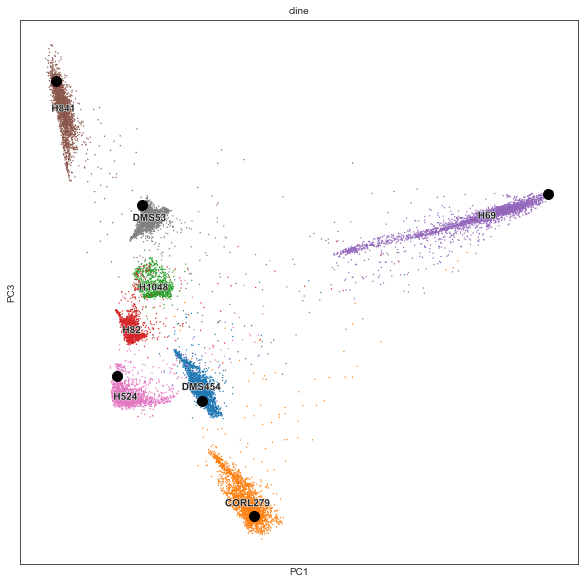

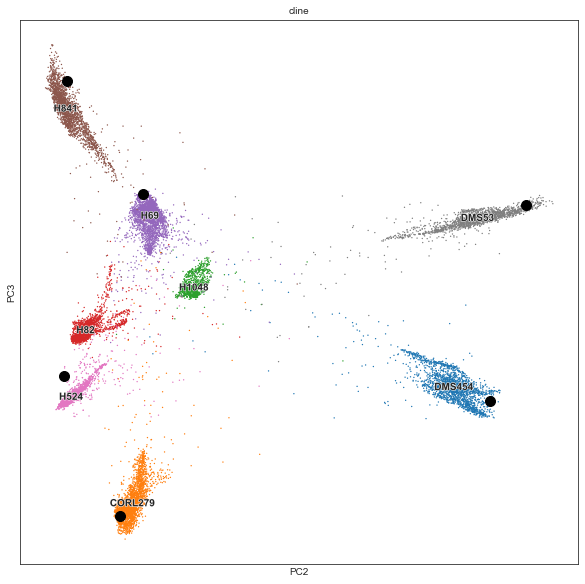

In [15]:
XC_6_8comp, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:8].T, noc=6, delta=0.1)
XC_6_8comp = np.array(XC_6_8comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'cline', components=components, show=False, figsize= (10,10), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_6_8comp[int(comp[0])-1], XC_6_8comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [289]:
XC_df = pd.DataFrame(XC_5_50comp)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5']


In [290]:
X_magic_pca_df = pd.DataFrame(X_magic.obsm['X_pca'], index = X_magic.obs_names)
X_magic_full_df = X_magic_pca_df.append(XC_df.T)
X_magic_full_df.head()

0          1         2   \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -0.533001  15.783157 -4.999127   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454 -1.523991  13.803243 -5.344131   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454 -0.907271  16.635292 -5.618718   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -0.573030  15.642927 -5.679330   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454 -0.149213  14.805091 -4.791946   

                                                     3          4         5   \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454  4.431529  12.344715 -0.994273   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454  5.951599  12.662260  0.173870   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454  4.974217  13.788206 -1.106682   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454  5.476871  13.618507 -0.932564   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454  4.477124  12.224570 -0.283122   

                                                     6         7         8   \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -1.582305 -0.146019 -2.353136   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454  0.809394  4.074553  2.872071   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454 -1.578936  0.021298 -1.360840   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -1.982671 -2.147378  0.010732   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454 -0.215432 -1.115614  3.613449   

                                                     9   ...        40  \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -0.403415  ...  0.093539   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454 -2.464070  ... -0.042050   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454  0.362825  ...  0.040892   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -1.053164  ...  0.010547   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454  3.655601  ...  0.199946   

                                                     41        42        43  \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -0.044980 -0.184641  0.154725   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454 -0.104556 -0.057729 -0.049952   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454 -0.090968  0.053040  0.018579   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -0.176261 -0.163170  0.032600   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454 -0.246780 -0.148420 -0.108300   

                                                     44        45        46  \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454  0.229788 -0.019431 -0.279231   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454  0.222943 -0.012697 -0.111233   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454  0.115013 -0.023503 -0.094937   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454  0.065155 -0.001316 -0.088550   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454 -0.307141  0.144003 -0.073842   

                                                     47        48        49  
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -0.593771 -0.075851 -0.083872  
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454 -0.060783  0.063759 -0.083973  
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454 -0.160806  0.062553 -0.120318  
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -0.098884  0.027512  0.091969  
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454  0.219010 -0.243986 -0.236940  

[5 rows x 50 columns]

In [318]:
pdx = squareform(pdist(X_magic_full_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=X_magic_full_df.index, columns=X_magic_full_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
X_magic.obsm['arc_distance'] = pdx_df.T

Now that we have a euclidean distance to each archetype on the MAGIC imputed data, we can find a neighborhood with arbritrary radius to classify cells closest to each archetype as specialists. In Van Dijk et al., they choose a radius (distance on diffusion map) that is 1/2 the minimum of the distance between archetypes.

In [285]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [299]:
X_magic.obsm['arc_distance']['Arc_1']

2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454    35.336282
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454    34.107496
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454    36.472817
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454    35.840855
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454    34.946838
                                                   ...    
2639-SM-2-CTTGTA_S2:TTTGTGTCGGCCCTTAx-DMS53      35.113936
2639-SM-2-CTTGTA_S2:TTTGTGTCCACAAGGCx-DMS53      35.382322
2639-SM-2-CTTGTA_S2:TTTGTGTCCTGTTCTTx-DMS53      36.423780
2639-SM-2-CTTGTA_S2:TTTGTGTCCCCATCTGx-DMS53      33.513066
2639-SM-2-CTTGTA_S2:TTTGTGTCCAGTTTGCx-DMS53      37.469797
Name: Arc_1, Length: 16108, dtype: float64

In [322]:
tmp = X_magic.obsm['arc_distance'].copy()

In [328]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic.obsm['arc_distance'].columns:
    closest = X_magic.obsm['arc_distance'].loc[X_magic.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [334]:
X_magic.obs['specialists_pca_diffdist'] = tmp.specialist

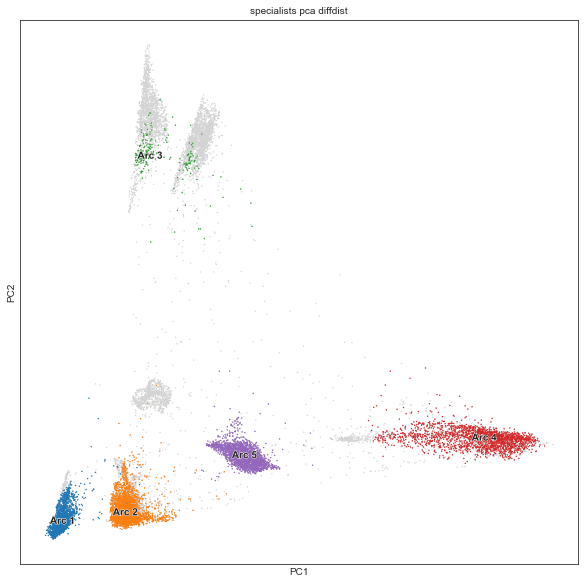

In [335]:
scv.pl.pca(X_magic, color = 'specialists_pca_diffdist', figsize= (10,10), frameon=True)


In [339]:
tmp.specialist = tmp.specialist.fillna('None')


In [341]:
pd.crosstab(tmp.specialist, X_magic.obs.cline)

cline       DMS454  CORL279  H1048   H82   H69  H841  H524  DMS53
specialist                                                       
Arc_1            0        0      0     0     0  1921     0      0
Arc_2            0        0      0   625     0     0  2257      0
Arc_3           63        0      0     0     0     0     0    158
Arc_4            0        0      0     0  2005     0     0      0
Arc_5            0     2336      0     0     0     0     0      0
None          1944       49    949  1086   794   142    88   1691

## !!! Labeling cells based on random walk to absorbing states
From Chan et al:
We solve this problem by using the probabilistic knn graph-based Phenograph classifier as implemented in the Phenograph package80 and has been shown to be highly successful in cases of mixed phenotypes which are frequently observed in cancer (Laughney et al., 2020). As input, we provide representative labeled cells for each known cell type. As output, each unlabeled cell is assigned a probability of belonging to each known cell type (termed Markov absorption probability). In cases where the probability for a given cell type is close to 1, we can annotate the cell with that cell type. In cases where the cell-type probability distribution is spread evenly across all cell types, we can consider these cells to represent a mixed phenotype. To implement this method, we first must have labeled training data available. To this end, we identify cells that can be confidently assigned to each subtype prior to calculating Markov absorption probabilities. Using reference RNA-sequencing of bulk tumors comparing SCLC subtypes (described in section ‘‘Differential expression in bulk reference datasets’’), we used the top 30 overexpressed DEGs per SCLC subtype and calculated the average Z-score over this gene set for each cell. The top 100 highest scoring cells were then used as training examples for each cell type. Next, we constructed a Markov graph from the dataset. We first constructed a diffusion map based on the first 56 PCs to obtain the first 15 diffusion components (DCs) retained by eigengap. Using the Phenograph package, we transformed this diffusion graph additionally into a Jaccard graph between k-neighborhoods, which has been shown to be more robust to noise. The resulting graph represents a Markov chain where we can therefore calculate the Markov absorption probabilities for each unlabeled cell to reach a labeled cell of a given subtype. Based on the resulting probabilities for each subtype, we can then perform a hard classification of SCLC subtype by maximum likelihood, or consider the per-cell probabilities of SCLC-A, SCLC-N, and SCLC-P to be a deconvolution of mixed phenotype that can be readily represented by a 3-coordinate ternary graph, as implemented in the ggtern package (Hamilton and Ferry, 2018)(Figure 1F). Of note, hard classification of SCLC subtypes on the UMAP shows that our feature selection facilitates a visualization that shows separation of cells based on canonical SCLC subtype while demonstrating inter-patient diversity (Figures 1A and 1G). This visualization stands in contrast to a previously published visualization of SCLC circulating tumor cell-derived xenograft cells where discrete clusters of cells represent different patients consistent with inter-patient diversity but without demonstrating clear relationship between patients (Stewart et al., 2020).

In [575]:
!pip install phenograph

     |████████████████████████████████| 159 kB 1.7 MB/s            
     |████████████████████████████████| 236 kB 3.0 MB/s            


In [622]:
import phenograph

# crazy reshaping necessary because phenograph classify requires a list of arrays, one array per subtype
c, P = phenograph.classify(train=[np.reshape(examples, (1, -1)) for examples in np.array(XC_df.T)], test = X_magic.obsm['X_pca'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm


In [662]:
P.sum(axis = 1)

array([0., 0., 0., ..., 0., 0., 0.])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

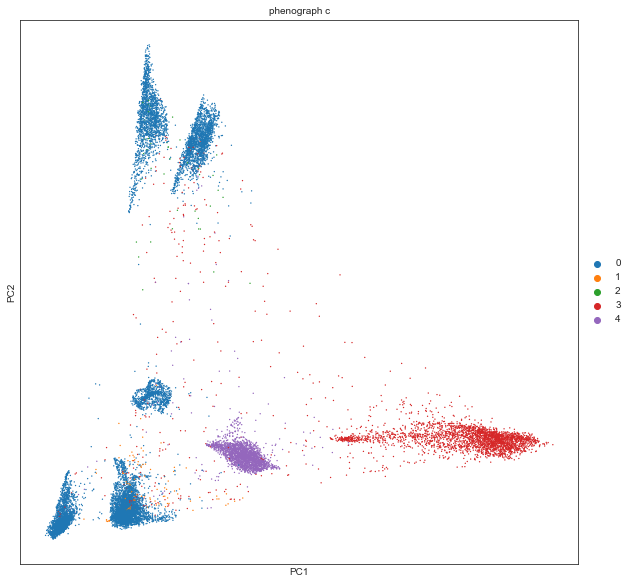

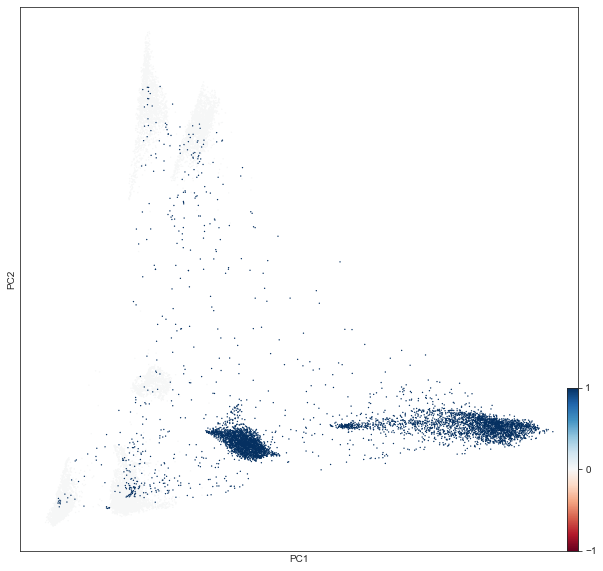

In [663]:
X_magic.obs['phenograph_c'] = c
X_magic.obsm['phenograph_P'] = P
scv.pl.pca(X_magic, c = 'phenograph_c', components='1,2', show=False, figsize= (10,10), frameon=True,  legend_loc = 'on right')

scv.pl.pca(X_magic, c = P.sum(axis = 1), components='1,2', show=False, figsize= (10,10), frameon=True, cmap = 'RdBu', norm=CenteredNorm(0) )


Using just the archetypes to train on doesn't work too well. I'm going to try to use the 100 closest cells to each archetype instead.

## Conclusions from PCHA on MAGIC imputed data  

It seems like 6 archetypes is the best, although one is CORL279 which we know has a lot of doublets. I'm going to try one more time without the doublets and see if the remaining CORL279 form their own archetype or not.

# PCHA on data without doublets

In [5]:
X_magic = sc.read_h5ad('../../out/cell-lines/X_magic_02.h5ad')

In [6]:
X_magic_no_doublets = X_magic.copy()
X_magic_no_doublets = X_magic_no_doublets[X_magic_no_doublets.obs.predicted_doublets_ind == 'False']

In [7]:
sc.pp.pca(X_magic_no_doublets)

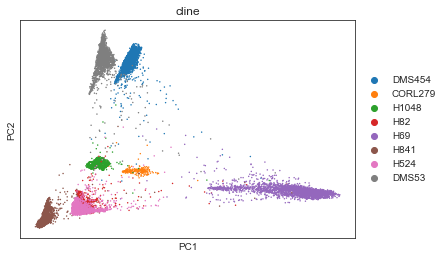

In [8]:
sc.pl.pca(X_magic_no_doublets, color='cline')

In [15]:
pca_var = X_magic_no_doublets.uns['pca']['variance_ratio']
cum_var = cumulative(pca_var)

print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

Knee of EV vs PC plot:  7


Knee in EV vs k plot for different k_max:
k_max = 8
K* = 5 archetypes, distance between k* and line:  0.12
k_max = 9
K* = 5 archetypes, distance between k* and line:  0.14
k_max = 10
K* = 5 archetypes, distance between k* and line:  0.16


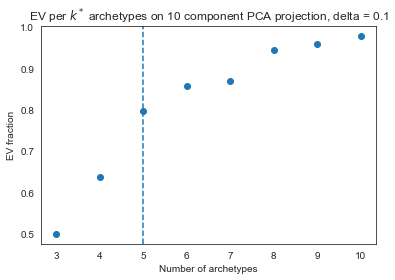

In [36]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(X_magic_no_doublets.obsm['X_pca'][:,0:10].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    # print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 10 component PCA projection, delta = 0.1")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.show()

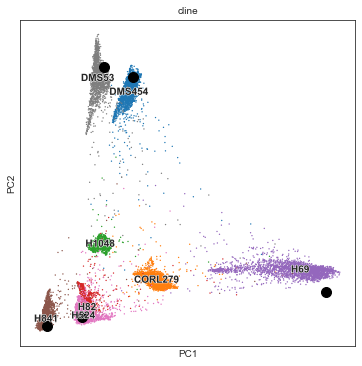

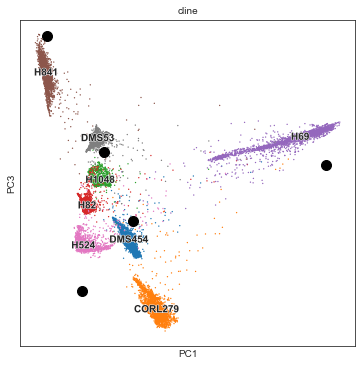

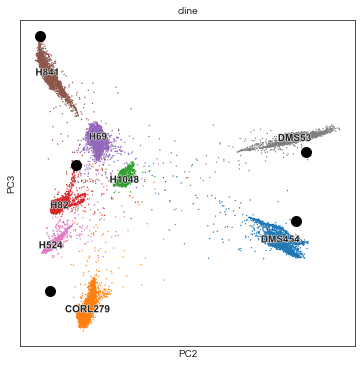

In [37]:
XC_5_50comp, S, C, SSE, varexpl = PCHA(X_magic_no_doublets.obsm['X_pca'][:,0:10].T, noc=5, delta=0.1)
XC_5_50comp = np.array(XC_5_50comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'cline', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_5_50comp[int(comp[0])-1], XC_5_50comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [85]:
X_magic_no_doublets

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'tot

In [38]:
XC_df = pd.DataFrame(XC_5_50comp)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5']


In [61]:
X_magic_pca_df = pd.DataFrame(X_magic_no_doublets.obsm['X_pca'][:,0:10], index = X_magic_no_doublets.obs_names)
X_magic_full_df = X_magic_pca_df.append(XC_df.T)
X_magic_full_df.head()

0          1         2  \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454  0.297357  16.006187 -3.005022   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454 -0.955937  13.990161 -2.548144   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454 -0.127615  16.944567 -3.415312   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454  0.118755  15.813581 -3.266056   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454  0.426313  14.838604 -2.953573   

                                                       3         4         5  \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454  13.413156 -0.333525 -2.345597   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454  14.570519  0.382021  0.298291   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454  15.001338 -0.445214 -2.567428   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454  14.925616 -0.305432 -2.728718   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454  13.119877  0.142188 -0.945053   

                                                      6         7         8  \
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -0.211354 -1.868033  1.242370   
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454  4.003258  2.667763 -0.233289   
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454 -0.274164 -1.420078  0.283029   
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -2.340291 -0.237957  0.641752   
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454 -1.133796  1.510664 -4.497880   

                                                      9  
2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454 -0.010672  
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454 -2.732406  
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454  0.176060  
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454 -0.513612  
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454  2.009967

In [63]:
pdx = squareform(pdist(X_magic_full_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=X_magic_full_df.index, columns=X_magic_full_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
X_magic_no_doublets.obsm['arc_distance'] = pdx_df.T

Now that we have a euclidean distance to each archetype on the MAGIC imputed data, we can find a neighborhood with arbritrary radius to classify cells closest to each archetype as specialists. In Van Dijk et al., they choose a radius (distance on diffusion map) that is 1/2 the minimum of the distance between archetypes.

In [64]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [72]:
X_magic_no_doublets.obsm['arc_distance']['Arc_1']

2637-SM-1-GCCAAT_S1:AAAACCTCCCACTCCTCx-DMS454    30.576472
2637-SM-1-GCCAAT_S1:AAAACCTCCACGAAACGx-DMS454    29.856384
2637-SM-1-GCCAAT_S1:AAAAGCCTATAGTCGCAx-DMS454    31.902972
2637-SM-1-GCCAAT_S1:AAAACCTCCTTTACCCTx-DMS454    31.162007
2637-SM-1-GCCAAT_S1:AAAAGCCTACACAAGGCx-DMS454    29.870696
                                                   ...    
2639-SM-2-CTTGTA_S2:TTTGTGTCGGCCCTTAx-DMS53      31.535046
2639-SM-2-CTTGTA_S2:TTTGTGTCCACAAGGCx-DMS53      30.996760
2639-SM-2-CTTGTA_S2:TTTGTGTCCTGTTCTTx-DMS53      33.185263
2639-SM-2-CTTGTA_S2:TTTGTGTCCCCATCTGx-DMS53      31.190009
2639-SM-2-CTTGTA_S2:TTTGTGTCCAGTTTGCx-DMS53      33.968771
Name: Arc_1, Length: 13945, dtype: float64

In [66]:
tmp = X_magic_no_doublets.obsm['arc_distance'].copy()

In [67]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic_no_doublets.obsm['arc_distance'].columns:
    closest = X_magic_no_doublets.obsm['arc_distance'].loc[X_magic_no_doublets.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [68]:
X_magic_no_doublets.obs['specialists_pca_diffdist'] = tmp.specialist

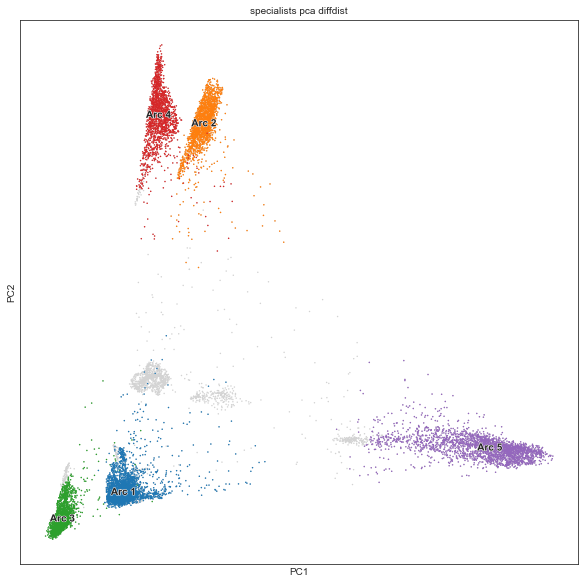

In [69]:
scv.pl.pca(X_magic_no_doublets, color = 'specialists_pca_diffdist', figsize= (10,10), frameon=True)


In [70]:
tmp.specialist = tmp.specialist.fillna('None')


In [71]:
pd.crosstab(tmp.specialist, X_magic.obs.cline)

cline       DMS454  CORL279  H1048   H82   H69  H841  H524  DMS53
specialist                                                       
Arc_1            3        1      2  1121     3     6  2339      0
Arc_2         1985        0      1     0     0     0     0      0
Arc_3            0        0      0     0     0  1960     0      0
Arc_4            0        0      0     0     0     0     0   1778
Arc_5            2        2      1     4  2583     3     1      2
None            15      225    945   584   211    94     5     69

## Labeling by Phenograph

In [76]:
list_idx = []
list_type = []
list_train = []
for i in pdx_df.index:
    tmp_sort = pdx_df.T.sort_values(i).iloc[0:int(.01*len(pdx_df.columns))]
    tmp_list = tmp_sort.index
    for f in tmp_list:
        list_idx.append(f)
        list_type.append(i)
    tmp_arr = np.array(X_magic_pca_df.loc[tmp_list])
    list_train.append(tmp_arr)

In [77]:
import phenograph
test = X_magic_pca_df.copy().drop(list_idx)
# crazy reshaping necessary because phenograph classify requires a list of arrays, one array per subtype
# c, P = phenograph.classify(train=[np.reshape(examples, (1, -1)) for examples in np.array(arc_pca_df.drop('color',axis = 1))], test = magic_pca_df)
c, P = phenograph.classify(train=list_train, test = test)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm


In [92]:
test_adata = X_magic_no_doublets[test.index].copy()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

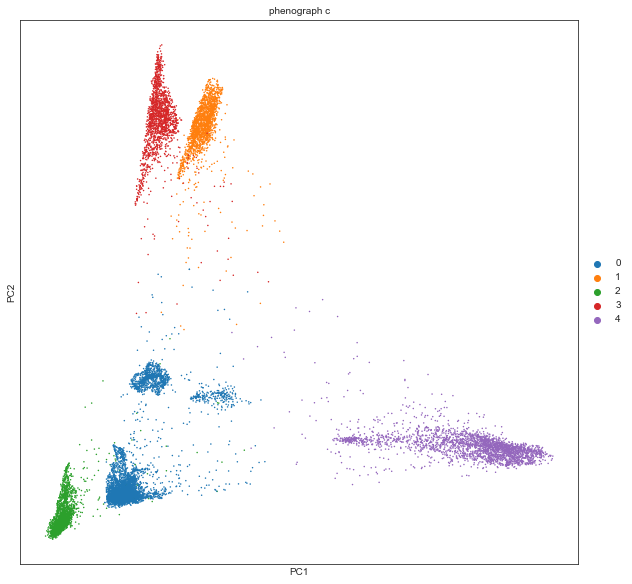

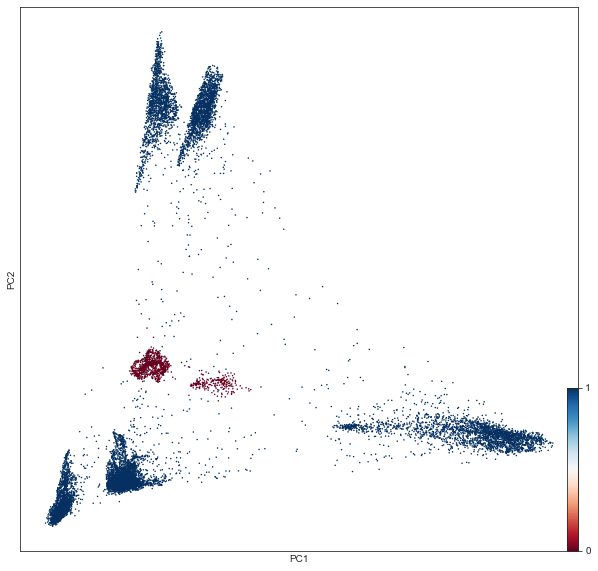

In [97]:
test_adata.obs['phenograph_c'] = c
test_adata.obsm['phenograph_P'] = P
scv.pl.pca(test_adata, c = 'phenograph_c', components='1,2', show=False, figsize= (10,10), frameon=True,  legend_loc = 'on right')

scv.pl.pca(test_adata, c = P.sum(axis = 1), components='1,2', show=False, figsize= (10,10), frameon=True, cmap = 'RdBu')


In [102]:
test_adata[test_adata.obs.cline == 'CORL279'].obsm['phenograph_P']

ArrayView(8.)

# PCHA on MAGIC imputed data after scanorama

## MAGIC on Scanorama corrected data

I also want to try applying MAGIC to the batch corrected data to see if it gives us a different result. If not, we will probably stick with the un-batch-corrected data to change the data as little as possible.

In [265]:
adata_SC = sc.read_h5ad("../../out/cell-lines/adata_SC_01.h5ad")
sc.pp.filter_genes(adata_SC, min_cells=3)
magic_operator_scan = magic.MAGIC(solver='approximate')
X_magic_scanorama = magic_operator_scan.fit_transform(adata_SC)

Calculating MAGIC...
  Running MAGIC on 16108 cells and 20596 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 112.61 seconds.
    Calculating KNN search...
    Calculated KNN search in 31.96 seconds.
    Calculating affinities...
    Calculated affinities in 34.05 seconds.
  Calculated graph and diffusion operator in 178.64 seconds.
  Calculating imputation...
  Calculated imputation in 0.06 seconds.
Calculated MAGIC in 181.55 seconds.


## PCA on MAGIC Scanorama data

In [267]:
sc.pp.pca(X_magic_scanorama)

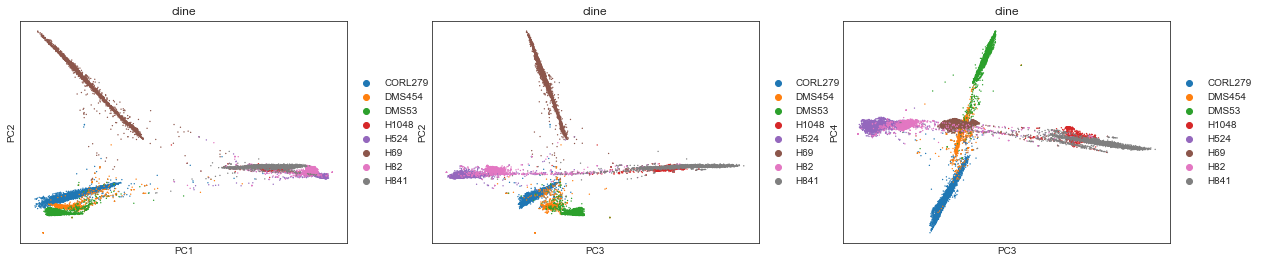

In [268]:
sc.pl.pca(X_magic_scanorama, color='cline', components=['1,2', '3,2', '3,4'])

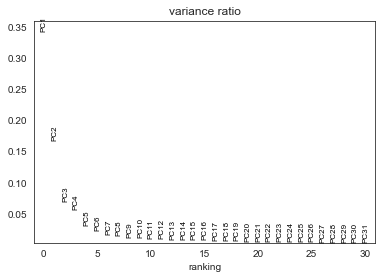

In [269]:
sc.pl.pca_variance_ratio(X_magic_scanorama)

In [270]:
X_magic_scanorama.write_h5ad('../../out/cell-lines/X_magic_scanorama_02.h5ad')

In [273]:
pca_var = X_magic_scanorama.uns['pca']['variance_ratio']

tot_exp_var = 0
n = 0
for i in pca_var:
    n +=1
    tot_exp_var += i
    if tot_exp_var > .8: 
        print(n)
        break

17


## PCHA on MAGIC Scanorama data

In this dataset, we need slightly more PCs to reach the same level of explained variance.

Knee in EV vs k plot for different k_max:
k_max = 8
K* = 5 archetypes, distance between k* and line:  0.05
k_max = 9
K* = 5 archetypes, distance between k* and line:  0.06
k_max = 10
K* = 5 archetypes, distance between k* and line:  0.07


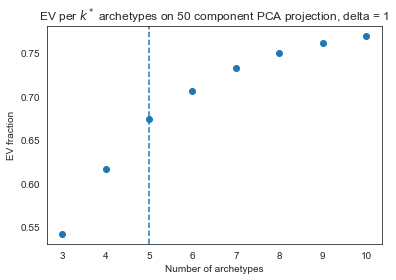

In [274]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(X_magic_scanorama.obsm['X_pca'].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    # print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 50 component PCA projection, delta = {delta}")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.savefig(f'../../figures/EV_per_k_scanorama_clines_delta_0.1.pdf')
plt.show()

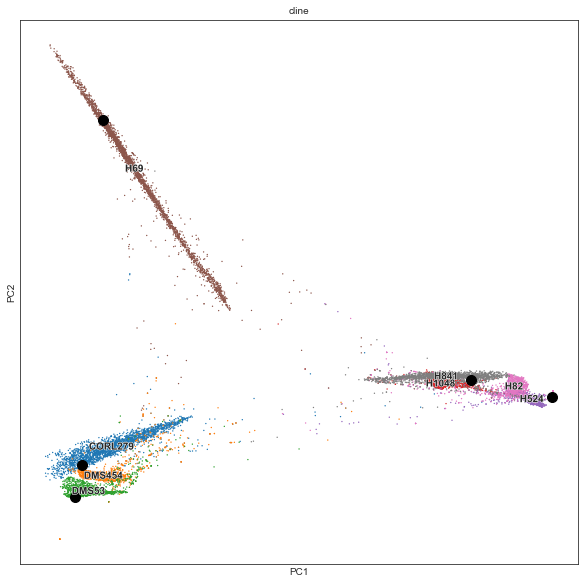

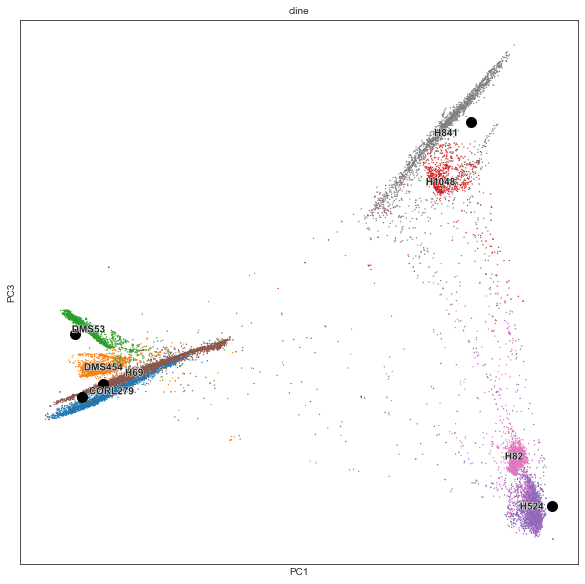

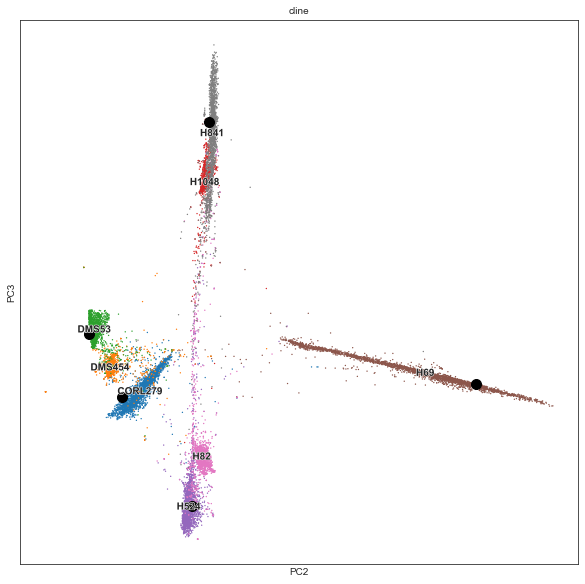

In [275]:
XC_scanorama, S, C, SSE, varexpl = PCHA(X_magic_scanorama.obsm['X_pca'].T, noc=5, delta=0.1)
XC_scanorama = np.array(XC_scanorama)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic_scanorama, color = 'cline', components=components, show=False, figsize= (10,10), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_scanorama[int(comp[0])-1], XC_scanorama[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()


## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [342]:
XC_df = pd.DataFrame(XC_scanorama)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5']


In [348]:
X_magic_pca_df = pd.DataFrame(X_magic_scanorama.obsm['X_pca'], index = X_magic_scanorama.obs_names)
X_magic_full_scanorama_df = X_magic_pca_df.append(XC_df.T)
X_magic_full_scanorama_df.head()

0         1         2   \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279 -0.141413 -0.075434 -0.028579   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279 -0.168227 -0.078775 -0.032382   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279 -0.135984 -0.074327 -0.024976   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279 -0.102356 -0.047927 -0.014604   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279 -0.097692 -0.047519 -0.012685   

                                                      3         4         5   \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279 -0.114057 -0.026928 -0.030045   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279 -0.130697 -0.027156 -0.044438   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279 -0.104301 -0.018707 -0.022140   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279 -0.088808  0.010362 -0.036843   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279 -0.072455  0.010024 -0.022526   

                                                      6         7         8   \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279 -0.002582 -0.032526 -0.002553   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279  0.008475 -0.036431  0.006627   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279 -0.002197 -0.026818 -0.000073   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279 -0.003906  0.015714 -0.004023   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279 -0.006210  0.010713 -0.006576   

                                                      9   ...        40  \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279  0.003266  ... -0.000019   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279 -0.001146  ...  0.002955   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279  0.005226  ... -0.000266   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279  0.009625  ...  0.000392   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279  0.010895  ...  0.001160   

                                                      41        42        43  \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279  0.010906 -0.001163 -0.011019   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279  0.011798  0.000620 -0.005120   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279  0.015131 -0.002257 -0.006576   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279 -0.005682 -0.000851  0.003921   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279  0.004129 -0.002063  0.003405   

                                                      44            45  \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279 -0.008998  8.567768e-07   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279 -0.004109 -8.127596e-04   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279 -0.002217  1.745969e-03   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279  0.004763  2.206145e-03   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279  0.002656  5.314335e-03   

                                                      46        47        48  \
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279 -0.005937 -0.003005  0.007886   
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279 -0.018996 -0.000961  0.005713   
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279 -0.011571 -0.002916  0.007473   
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279  0.006274  0.001738 -0.003812   
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279 -0.007697 -0.002936  0.001121   

                                                      49  
2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279  0.012039  
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279  0.006473  
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279  0.001964  
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279 -0.004381  
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279 -0.002824  

[5 rows x 50 columns]

In [349]:
pdx = squareform(pdist(X_magic_full_scanorama_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=X_magic_full_scanorama_df.index, columns=X_magic_full_scanorama_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
X_magic_scanorama.obsm['arc_distance'] = pdx_df.T

Now that we have a euclidean distance to each archetype on the MAGIC imputed data, we can find a neighborhood with arbritrary radius to classify cells closest to each archetype as specialists. In Van Dijk et al., they choose a radius (distance on diffusion map) that is 1/2 the minimum of the distance between archetypes.

In [350]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [351]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype
tmp = X_magic_scanorama.obsm['arc_distance'].copy()
for arc in  X_magic_scanorama.obsm['arc_distance'].columns:
    closest = X_magic_scanorama.obsm['arc_distance'].loc[X_magic_scanorama.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [352]:
X_magic_scanorama.obs['specialists_pca_diffdist'] = tmp.specialist

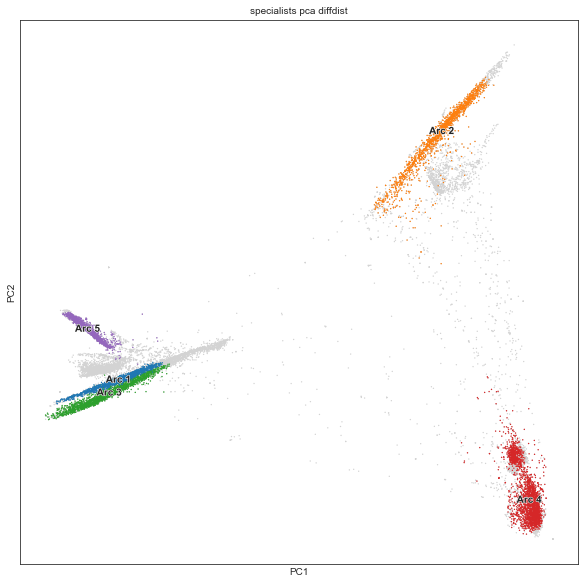

In [357]:
scv.pl.pca(X_magic_scanorama, color = 'specialists_pca_diffdist', components="1,3",figsize= (10,10), frameon=True)


In [354]:
tmp.specialist = tmp.specialist.fillna('None')


In [356]:
pd.crosstab(tmp.specialist, X_magic.obs.cline).style.background_gradient("viridis")

# Write out the data

In [16]:
adata.write_h5ad('../../out/cell-lines/adata_02.h5ad')

In [308]:
adata_no_doublets = adata.copy()
adata_no_doublets = adata_no_doublets[adata_no_doublets.obs.predicted_doublets_ind == 'False']

In [312]:
adata_no_doublets.write_h5ad("../../out/cell-lines/adata_no_doublets_02.h5ad")

In [17]:
X_magic.write_h5ad("../../out/cell-lines/X_magic_02.h5ad")

In [485]:
X_magic_scanorama.write_h5ad("../../out/cell-lines/X_magic_scanorama_02.h5ad")

In [16]:
X_magic_no_doublets.write_h5ad("../../out/cell-lines/X_magic_no_doublets_02.h5ad")

## Write out data for ParetoTI 
T ratio calculation and comparison of single cell archetypes to bulk archetypes using enrichments


We will run archetype analysis using ParetoTI, and compare the single cell and bulk archetypes using the Hausser code (hypergeometric tests on enrichments). We will use the PCA of the MAGIC imputed data.

In [183]:
X_magic_for_R = X_magic.copy()

In [186]:
X_magic_for_R

AnnData object with n_obs × n_vars = 16108 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'specialists_pca_diffdist', 'cell_cycle_diff'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'n_cells'
    uns: 'cline_color

In [193]:
#Get rid of arc_distance, which causes a problem in R
X_magic_for_R.obsm = {'X_pca':X_magic_for_R.obsm['X_pca']}

In [200]:
for col in ['specialists_pca_diffdist']:
    X_magic_for_R.obs[col]=X_magic_for_R.obs[col].cat.add_categories("Unknown").fillna('Unknown')

In [201]:
X_magic_for_R.obs.isnull().values.any()

False

In [202]:
X_magic_for_R.write_h5ad("../../out/cell-lines/X_magic_for_R.h5ad")

And with scanorama:

In [203]:
X_magic_scanorama_for_R = X_magic_scanorama.copy()

In [204]:
X_magic_scanorama_for_R

AnnData object with n_obs × n_vars = 16108 × 20596
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'n_cells'
    uns: 'cline_colors', 'pca', 'specialists_pca_diffdist_colors'
    obsm: 'X_pca', 'arc_distance'
    varm: 'PCs'

`obsm['arc_distance']` is not working in the Seurat version of the Anndata, so we'll remove this.

In [205]:
X_magic_scanorama_for_R.obsm = {'X_pca':X_magic_scanorama_for_R.obsm['X_pca']}

In [208]:
X_magic_scanorama_for_R.obs.specialists_pca_diffdist

2637-SM-2-CTTGTA_S2:AAAACGCCTGATTAGACx-CORL279    Arc_3
2637-SM-2-CTTGTA_S2:AAAACTCGAAGAAGTTAx-CORL279    Arc_3
2637-SM-2-CTTGTA_S2:AAAACCTCCCTACCGTTx-CORL279    Arc_3
2637-SM-2-CTTGTA_S2:AAAACGCCTGCCAAGATx-CORL279    Arc_3
2637-SM-2-CTTGTA_S2:AAAACCTCCACGCAGAGx-CORL279    Arc_3
                                                  ...  
2638-SM-4-GTGAAA_S4:TTTGTGTCCGATTGATx-H841          NaN
2638-SM-4-GTGAAA_S4:TTTGTGTCCCTGTTATx-H841        Arc_2
2638-SM-4-GTGAAA_S4:TTTGTGTCGTGTAACCx-H841        Arc_2
2638-SM-4-GTGAAA_S4:TTTGTGTCTCACCGAGx-H841        Arc_2
2638-SM-4-GTGAAA_S4:TTTGTGTCCGTAGAAGx-H841        Arc_2
Name: specialists_pca_diffdist, Length: 16108, dtype: category
Categories (5, object): ['Arc_1', 'Arc_2', 'Arc_3', 'Arc_4', 'Arc_5']

In [211]:
for col in ['specialists_pca_diffdist']:
    X_magic_scanorama_for_R.obs[col]=X_magic_scanorama_for_R.obs[col].cat.add_categories("Unknown").fillna('Unknown')

In [212]:
X_magic_scanorama_for_R.obs.isnull().values.any()

False

In [213]:
X_magic_scanorama_for_R.write_h5ad("../../out/cell-lines/X_magic_scanorama_for_R.h5ad")

And without doublets:

In [17]:
X_magic_no_doublets_for_R = X_magic_no_doublets.copy()

In [18]:
X_magic_no_doublets_for_R

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_cou

`obsm['arc_distance']` is not working in the Seurat version of the Anndata, so we'll remove this.

In [19]:
X_magic_no_doublets_for_R.obsm = {'X_pca':X_magic_no_doublets_for_R.obsm['X_pca']}

In [22]:
X_magic_no_doublets_for_R.obs.isnull().values.any()

False

In [23]:
X_magic_no_doublets_for_R.write_h5ad("../../out/cell-lines/X_magic_no_doublets_for_R.h5ad")

# Projection of Single Cell Data into Bulk PCA

**IMPORTANT** We will read in the single cell data without doublets, but are replacing the names above (i.e. adata and X_magic)!

In [388]:
adata = sc.read_h5ad('../../out/cell-lines/adata_no_doublets_02.h5ad')

In [389]:
X_magic = sc.read_h5ad('../../out/cell-lines/X_magic_no_doublets_02.h5ad')

We read in the cell lines, rescale, and run a PCA (which mean-center the data). N.B. the archetype location gene lists got messed up from Excel dates, so we remove the genes that no longer match.

In [390]:
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
def fit_bulk_pca(adata_var_names):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    # bulk = bulk / np.linalg.norm(bulk, axis=0)

    pca = PCA(n_components=20)
    data_pca = pca.fit_transform(bulk.T)
    pca_df = pd.DataFrame(data_pca)
    
    arc = pd.read_csv('../../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
    arc_genes = pd.read_csv('../../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
    arc.columns = arc_genes[0]
    arc = arc.T
    arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']
    arc = arc.loc[shared_genes]
    arc = pd.DataFrame(pp.scale(arc), columns = arc.columns, index = arc.index)

    # arc = arc / np.linalg.norm(arc, axis=0)

    arc_pca = pca.transform(arc.T)
    arc_pca_df = pd.DataFrame(arc_pca, index=arc.columns)
    arc_pca_df['color'] = arc.columns
    
    return pca, pca_df, arc_pca_df, shared_genes

## Projection of Original Single Cell Data
We compare the original (filtered, normalized, log-transformed) single cell data directly to the bulk archetypes by transforming with the same PCA.

In [391]:
pca, pca_df, arc_pca_df, shared_genes = fit_bulk_pca(adata.var_names)

In [392]:
def transform_data(adata, pca, shared_genes, layer = 'X'):
    tmp = adata[:,shared_genes].copy()
    if layer == 'X':
        adata_df = pd.DataFrame(tmp.X, index=tmp.obs_names, columns=tmp.var_names)
    else:
        adata_df = pd.DataFrame(tmp.layers[layer].todense(), index=tmp.obs_names, columns=tmp.var_names)

    adata_df = adata_df.T
    adata_df = pd.DataFrame(pp.scale(adata_df), columns = adata_df.columns, index = adata_df.index)

    # adata_df = adata_df / np.linalg.norm(adata_df, axis=0)

    adata_pca = pca.transform(adata_df.T)
    adata_pca_df = pd.DataFrame(adata_pca, index=adata_df.columns)
    tot_var_full = adata_df.T.var().sum()
    varexpl = adata_pca_df.var() #var explained by bulk PCA
    return adata_df, adata_pca_df, {'tot_var_full':tot_var_full, 'varexpl':varexpl}


In [393]:
adata_df, adata_pca_df, adata_var_dict = transform_data(adata, pca, shared_genes)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


<AxesSubplot:xlabel='0', ylabel='1'>

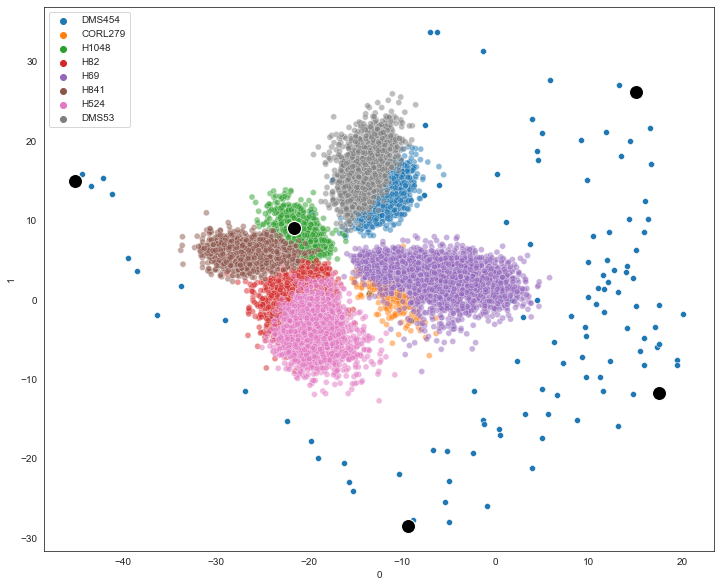

In [394]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1])
sns.scatterplot(-adata_pca_df[0], adata_pca_df[1], hue = adata.obs.cline, alpha = .5)
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)

# sns.scatterplot(-adata_arc.loc[pcs_to_plot[0]],-adata_arc.loc[pcs_to_plot[1]], hue =  adata.obs['cline'])#adata.obs['cline'].values)
# sns.scatterplot(-sc_arc_genes_pc.loc[pcs_to_plot[0]],-sc_arc_genes_pc.loc[pcs_to_plot[1]], color = 'black')

# plt.figure(figsize = (12,10))
# sns.scatterplot(-adata_arc.loc[pcs_to_plot[0]],-adata_arc.loc[pcs_to_plot[1]], hue =  all_df['cluster'], 
#                 palette = [cp[0],cp[1],cp[2],cp[3],'grey',cp[4]])#adata.obs['cline'].values)
# sns.scatterplot(-sc_arc_genes_pc.loc[pcs_to_plot[0]],-sc_arc_genes_pc.loc[pcs_to_plot[1]], color = 'black')


# plt.show()
# plt.figure(figsize = (12,10))
# sns.scatterplot(-adata_arc.loc[pcs_to_plot[0]],-adata_arc.loc[pcs_to_plot[1]], hue =  adata.obs['Phenotype'].values,
#                palette = ['grey','lightgrey','red','orange','green','blue','purple'])#
# sns.scatterplot(-sc_arc_genes_pc.loc[pcs_to_plot[0]],-sc_arc_genes_pc.loc[pcs_to_plot[1]], color = 'black')


### Compare the variance explained to the variance explained by shuffled PCs.

In [434]:
def EV_shuffled_fit(adata_var_names, adata_df, n_components = 20, n_shuffles = 10):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    ev = []
    for i in range(n_shuffles):
        ran = shuffle(bulk)
        ran.index = bulk.index
        ran_pca = PCA(n_components=n_components)
        ran_data_pca = ran_pca.fit_transform(ran.T)
        ran_pca_df = pd.DataFrame(ran_data_pca)
        adata_pca_rand = ran_pca.transform(adata_df.T)
        adata_pca_rand_df = pd.DataFrame(adata_pca_rand, index=adata_df.columns)
        ev.append(list(adata_pca_rand_df.var()))

    return ev

In [396]:
adata_var_dict['shuffled_fit_EV'] = EV_shuffled_fit(adata.var_names, adata_df)

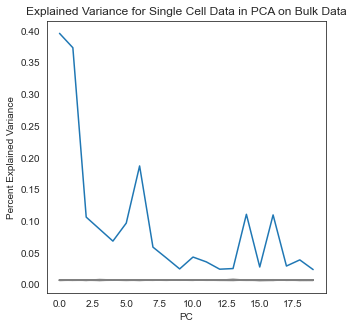

In [397]:
plt.figure(figsize = (5,5))
plt.plot(100*adata_var_dict['varexpl']/adata_var_dict['tot_var_full'])
for i in range(10):
    plt.plot([100*x for x in adata_var_dict['shuffled_fit_EV'][i]/adata_var_dict['tot_var_full']], c = 'grey')
plt.title('Explained Variance for Single Cell Data in PCA on Bulk Data')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

In [398]:
#ev_df for seaborn 
flat_list = [item for sublist in adata_var_dict['shuffled_fit_EV'] for item in sublist]
ev_df = pd.DataFrame(10*list(range(20)), columns=['PC'])
ev_df['ev'] = [100*i/adata_var_dict['tot_var_full'] for i in flat_list]

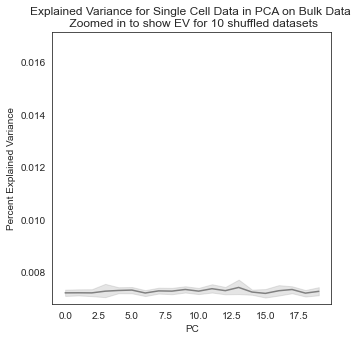

In [399]:
plt.figure(figsize = (5,5))
plt.plot(100*adata_var_dict['varexpl']/adata_var_dict['tot_var_full'])
# for i in range(10):
#     plt.plot([100*x for x in ev[i]], c = 'grey')
sns.lineplot(data = ev_df, x = 'PC', y = 'ev', color = 'grey')
plt.ylim(ev_df['ev'].min(),2*ev_df['ev'].max())
plt.title('Explained Variance for Single Cell Data in PCA on Bulk Data \n Zoomed in to show EV for 10 shuffled datasets')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

## Projection of MAGIC imputed data

### Fit single cell MAGIC data

In [400]:
magic_df, magic_pca_df, magic_var_dict = transform_data(X_magic, pca, shared_genes)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


<AxesSubplot:xlabel='0', ylabel='1'>

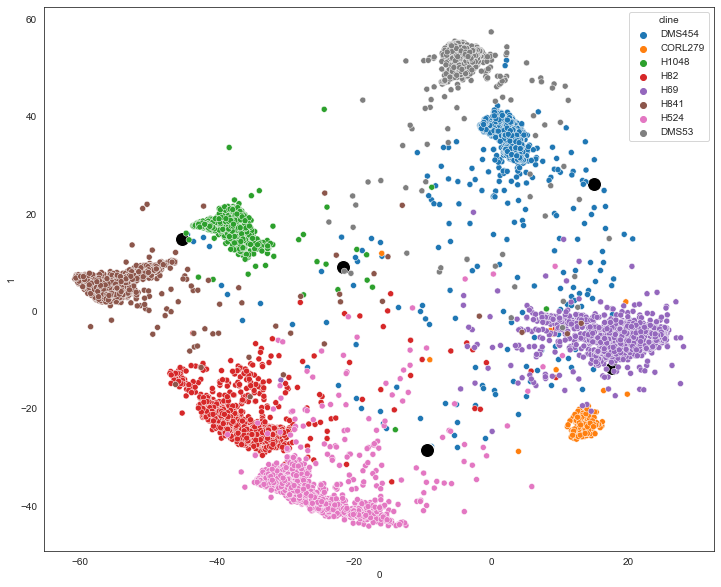

In [401]:

plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1])
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
sns.scatterplot(-magic_pca_df[0], magic_pca_df[1], hue =  X_magic.obs['cline'])


### Compare the variance explained to the variance explained by PCA fit to shuffled data.

Total variance in imputed and scaled single cell dataset:

In [402]:
magic_var_dict['shuffled_fit_EV'] = EV_shuffled_fit(X_magic.var_names, magic_df)

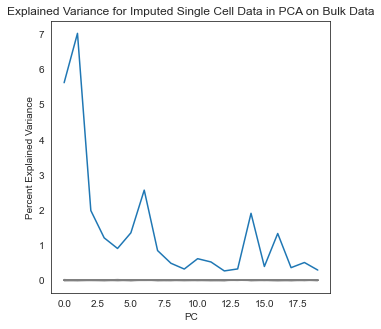

In [403]:
plt.figure(figsize = (5,5))
plt.plot(100*magic_var_dict['varexpl']/magic_var_dict['tot_var_full'])
for i in range(10):
    plt.plot([100*x for x in magic_var_dict['shuffled_fit_EV'][i]/magic_var_dict['tot_var_full']], c = 'grey')
plt.title('Explained Variance for Imputed Single Cell Data in PCA on Bulk Data')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

In [404]:
def pca_upperbound(adata_df, n_components=20):
    pca_sc = PCA(n_components=n_components)
    pca_sc_transformed = pca_sc.fit_transform(adata_df.T)
    pca_sc_transformed_df = pd.DataFrame(pca_sc_transformed, index=adata_df.columns)
    EV_adata_only = pca_sc_transformed_df.var()
    return EV_adata_only
magic_var_dict['EV_upperbound'] = pca_upperbound(magic_df)

In [405]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

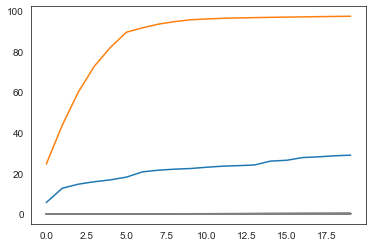

In [406]:
sns.lineplot(range(20),100*(Cumulative(magic_var_dict['varexpl'])/magic_var_dict['tot_var_full']))
sns.lineplot(range(20),100*(Cumulative(magic_var_dict['EV_upperbound'])/magic_var_dict['tot_var_full']))
for i in range(10):
    plt.plot([100*x for x in Cumulative(magic_var_dict['shuffled_fit_EV'][i])/magic_var_dict['tot_var_full']], c = 'grey')


<AxesSubplot:>

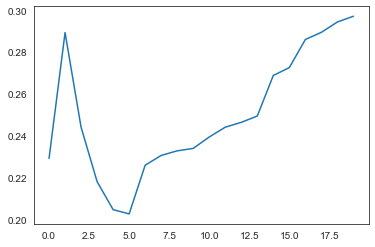

In [407]:
sns.lineplot(range(20),[i/j for i, j in zip(Cumulative(magic_var_dict['varexpl']),Cumulative(magic_var_dict['EV_upperbound']))])


### Compare the variance explained to the variance in shuffled data explained by PCA.

In [408]:
# Shuffling preserves total variance in data
shuffle(magic_df).T.var().sum()

12135.325

In [409]:
def EV_shuffled_data(adata_var_names, adata_df, n_components = 20, n_shuffles = 10):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(bulk.T)
    pca_df = pd.DataFrame(data_pca)
    
    ev = []
    for i in range(n_shuffles):
        adata_pca_rand = pca.transform(shuffle(adata_df).T)
        adata_pca_rand_df = pd.DataFrame(adata_pca_rand, index=adata_df.columns)
        ev.append(list(adata_pca_rand_df.var()))

    return ev

In [410]:
magic_var_dict['shuffled_data_EV'] = EV_shuffled_data(X_magic.var_names, magic_df)

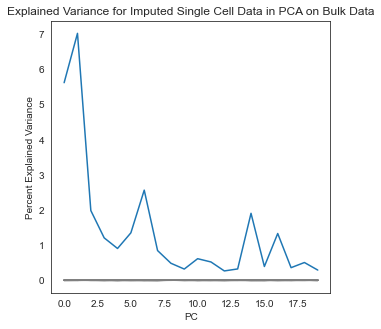

In [411]:
plt.figure(figsize = (5,5))
plt.plot(100*magic_var_dict['varexpl']/magic_var_dict['tot_var_full'])
for i in range(10):
    plt.plot([100*x for x in magic_var_dict['shuffled_data_EV'][i]/magic_var_dict['tot_var_full']], c = 'grey')
plt.title('Explained Variance for Imputed Single Cell Data in PCA on Bulk Data')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

In [412]:
#ev_df for seaborn 
flat_list = [item for sublist in magic_var_dict['shuffled_data_EV'] for item in sublist]
ev_df = pd.DataFrame(10*list(range(20)), columns=['PC'])
ev_df['ev'] = [100*i/magic_var_dict['tot_var_full'] for i in flat_list]

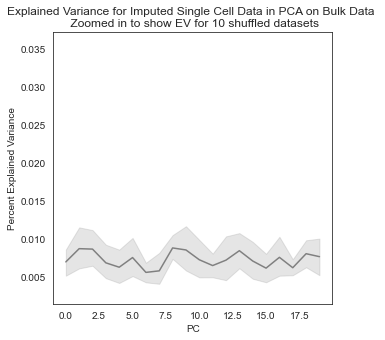

In [418]:
plt.figure(figsize = (5,5))
plt.plot(100*magic_var_dict['varexpl']/magic_var_dict['tot_var_full'])
# for i in range(10):
#     plt.plot([100*x for x in ev[i]], c = 'grey')
sns.lineplot(data = ev_df, x = 'PC', y = 'ev', color = 'grey')
plt.ylim(ev_df['ev'].min(),2*ev_df['ev'].max())
plt.title('Explained Variance for Imputed Single Cell Data in PCA on Bulk Data \n Zoomed in to show EV for 10 shuffled datasets')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

# Compare intra and inter-sample heterogeneity using Hausser code

**Comparing intra-tumor heterogeneity and inter-tumor diversity.**  (from Hausser et al.)
- To compare intratumor heterogeneity and intertumor diversity, we ﬁrst analyzed the single-cell gene expression using the Seurat package. Genes present in <5% of cells and outlier cells with <1500 or more than 8000 detectable genes were excluded from the analysis. 
- Gene expression data was normalized and scaled by the RNA count of each cell, the fraction of mitochondrial RNA, and the tumor of origin, as was done in the original study47. 
- After this ﬁltering, 650 single-cancer cells from six breast tumors were left for analysis. 
- We projected the single-cancer cells on the ﬁrst three principal components of metabric tumors5. *To do so, we focused on 1964 genes expressed in at least 50% of single-cancer cells and proﬁled in the metabric tumors, so that gene expression could be quantiﬁed in most cells, allowing projection of these cells on the space deﬁned by the ﬁrst three principal components of the metabric tumors.*
- To assess if intratumor heterogeneity and intertumor diversity are oriented in common directions of gene expression space, we computed the fraction of variance in gene expression explained by principal components computed on gene expression of metabric tumors. This fraction is necessarily bounded by the fraction of variance explained by principal components computed on gene expression from single cells. In other words, if intratumor heterogeneity and intertumor diversity were perfectly aligned in gene expression space, the fraction of variance explained by metabric principal components would equal the fraction of variance explained by single-cell principal components. 
- We used five PCs because of an elbow in the fraction of variance explained by single-cell PCs curve (Supplementary Fig. 4B).The first five metabric PCs explain 25.4 ± 3% of the variance explained by the first five single-cell PCs. This percentage is robust to using a different number of PCs(Supplementary Fig. 4C): varying the number of PCs from 5 to 50 keeps thepercentage in the 22–27% range. 
- To test if the fraction of variance explained by metabric PCs can be attributed to random structures in gene expression data, we shuffled the metabric gene expression by resampling expression of each gene. Doing so preserved the variance in the expression of each gene but destroyed correlations in the expression of different genes. The first five PCs of this shuffled dataset explain 1.5 ± 0.4% of the variance explained by single-cell PCs. A t-test supports the hypothesis that the first five metabric PCs explain significantly more variance in single cell gene expression than shuffled metabric PCs (p=0.0004, two-sided). Thus, intertumor diversity explains a significant fraction of intratumor heterogeneity.


## Measuring intra-sample heterogeneity

In [32]:
dist = squareform(pdist(X_magic.obsm['X_pca'], metric='euclidean')) # compute distances on pca
ITH = pd.DataFrame(columns = ['distance','cline'])

dist_df = pd.DataFrame(dist, index = X_magic.obs_names,columns = X_magic.obs_names)

for i in (X_magic.obs.cline.unique()):
    print(i)
    tmp_samples = X_magic[X_magic.obs.cline == i].obs_names
    tmp_dist = dist_df.loc[tmp_samples, tmp_samples]
    print(np.average(np.array(tmp_dist)))
    tmp_df = pd.concat([pd.Series(tmp_dist.mean()),pd.Series([i]*len(tmp_dist), index = tmp_dist.index)],ignore_index = True, axis = 1)
    tmp_df.columns = ['distance','cline']
    ITH = pd.concat([ITH, tmp_df])
    

DMS454
9.16152342699178
CORL279
10.045656472195173
H1048
8.7138407798839
H82
9.721941461178812
H69
19.645156150206116
H841
8.170106188844702
H524
7.7334340398343775
DMS53
7.82457529998547


In [39]:
!pip install statannot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DMS454 v.s. CORL279: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.795e-11 U_stat=1.622e+05
CORL279 v.s. H1048: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.179e-14 U_stat=1.450e+05
H1048 v.s. H82: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.434e-04 U_stat=7.266e+05
H82 v.s. H69: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.505e+05
H69 v.s. H841: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=5.486e+06
H841 v.s. H524: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.482e+06
H524 v.s. DMS53: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.000e-01 U_stat=2.081e+06
DMS454 v.s. H1048: Mann-Whitney

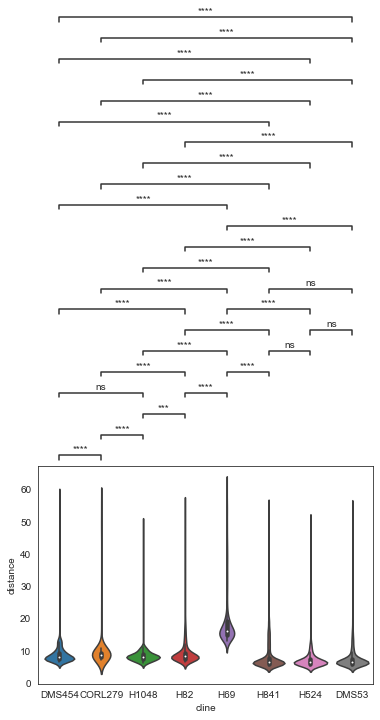

In [66]:
from itertools import combinations
from statannot import add_stat_annotation
ax = sns.violinplot(data = ITH, y = 'distance',x='cline')
test_results = add_stat_annotation(ax, data=ITH, y='distance', x='cline', 
                                   box_pairs= list(combinations(ITH.cline.unique(), 2)),
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

In [56]:
ITH.groupby('cline').mean().sort_values(by = 'distance')

distance
cline             
H524      7.733434
DMS53     7.824575
H841      8.170106
H1048     8.713841
DMS454    9.161523
H82       9.721941
CORL279  10.045656
H69      19.645156

In [55]:
distances = pd.read_csv('../../out/bulk/dist_to_bulk_arc.csv', index_col=0)

In [57]:
distance_df = distances.min(axis = 1).loc[[i for i in distances.index if i.split('.')[1] in ['NCIH69','NCIH82','NCIH1048','NCIH841','NCIH524','DMS53','DMS454','CORL279']]].sort_values()
                            

In [70]:
dist = squareform(pdist(adata.obsm['X_pca'], metric='euclidean')) # compute distances on pca

dist_df = pd.DataFrame(dist, index = adata.obs_names,columns = adata.obs_names)

for i in (adata.obs.cline.unique()):
    print(i)
    tmp_samples = adata[adata.obs.cline == i].obs_names
    tmp_dist = dist_df.loc[tmp_samples, tmp_samples]
    print(np.average(np.array(tmp_dist)))

DMS454
14.246282513353181
CORL279
11.932975706530565
H1048
11.471064632893599
H82
15.749456204576704
H69
28.174597909226318
H841
11.329497016108704
H524
11.086037314539475
DMS53
12.326852230788734


In [67]:
# for i in distances.columns:
#     print(i)
#     print(distances.sort_values(i)[0:12].index)
#     print(distances.loc[distances[i] < 100].index)

Overall, cell lines that are farther from their closest archetype have higher ITH, but not by much. Furthermore, if generalist samples were mixes of two populations close to archetypes, we'd expect the distribution of distances between cells to be bimodal. Instead, we see that all the distributions are more normal, with a long tail.

## Using only highly variable genes

### HVGs

In [419]:
X_norm = sc.pp.normalize_total(adata, layer='raw_counts', inplace = False)['X']
adata.layers["norm_counts"] = X_norm


adata.layers['log1p_norm_unscaled'] = np.log1p(adata.layers["norm_counts"])


hvgs = sc.pp.highly_variable_genes(adata, layer='log1p_norm_unscaled', inplace=False)

hvgs.index = adata.var_names

In [420]:
pca, pca_df, arc_pca_df, shared_genes = fit_bulk_pca(hvgs.loc[hvgs.highly_variable==True].index)

In [170]:
bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
bulk.head()

m.DMS153  m.NCIH60  m.NCIH69  m.NCIH82  m.NCIH128  m.NCIH146  \
A1BG    2.955199  3.239727  3.599770  3.055231   4.579507   4.685081   
A1CF    0.077212  0.167166  0.117398  0.536179   0.088160   0.074992   
A2M     2.267502  0.122302  0.085891  1.586479   0.064500   0.231189   
A2ML1   0.011011 -0.007241 -0.005086 -0.004471  -0.003819   0.011107   
A4GALT  2.453512  1.528297  1.428711  0.359365   0.865621   0.867495   

        m.NCIH187  m.NCIH209  m.NCIH211  m.NCIH250  ...  c.NCIH524  c.NCIH526  \
A1BG     3.215947   4.181752   1.288835   4.804468  ...   4.183146   3.405942   
A1CF     0.080727   0.079204   0.107217   0.090348  ...  -0.057567   0.623162   
A2M      0.059062   0.072303   0.189474   0.066101  ...  -0.038265  -0.006552   
A2ML1   -0.003497  -0.003431  -0.004644  -0.003914  ...   0.003116   0.006167   
A4GALT   2.455182   1.037618   0.265048   3.132071  ...   0.569911   1.458448   

        c.NCIH69  c.NCIH82  c.NCIH841  c.NCIH889    c.SBC5  c.SCLC21H  \
A1BG    4.256034  3.905371   4.436237   5.073359  4.423783   3.713345   
A1CF   -0.107734 -0.016782   0.183740   0.242981  0.008349   0.003494   
A2M     0.040540  0.221331   1.276428   0.039852  0.681201   0.032354   
A2ML1   0.006514  0.017533   0.015672   0.114451  0.043520   0.004658   
A4GALT  0.513539  0.191663   3.127982   0.086832  2.641161   0.764500   

         c.SHP77  c.SW1271  
A1BG    3.438644  4.209637  
A1CF   -0.073834 -0.001700  
A2M     1.635919  0.303402  
A2ML1   0.003820  0.031692  
A4GALT  0.861152  1.868799  

[5 rows x 120 columns]

In [171]:
bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]

In [172]:
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA

shared_genes = sorted(list(set(hvgs.loc[hvgs.highly_variable==True].index).intersection(bulk.index)))
bulk = bulk.loc[shared_genes]
bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
# bulk = bulk / np.linalg.norm(bulk, axis=0)

pca = PCA(n_components=20)
data_pca = pca.fit_transform(bulk.T)
pca_df = pd.DataFrame(data_pca)



We also read in the archetype locations and transform with the same PCA.

In [173]:
arc = pd.read_csv('../../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
arc_genes = pd.read_csv('../../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
arc.columns = arc_genes[0]
arc = arc.T
arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']


In [174]:
arc = arc.loc[shared_genes]
arc = pd.DataFrame(pp.scale(arc), columns = arc.columns, index = arc.index)

# arc = arc / np.linalg.norm(arc, axis=0)

arc_pca = pca.transform(arc.T)
arc_pca_df = pd.DataFrame(arc_pca, index=arc.columns)
arc_pca_df['color'] = arc.columns



In [175]:
tmp = adata[:,shared_genes].copy()
adata_df = pd.DataFrame(tmp.layers['log1p_norm_unscaled'].todense(), index=tmp.obs_names, columns=tmp.var_names)
adata_df = adata_df.T
adata_df = pd.DataFrame(pp.scale(adata_df), columns = adata_df.columns, index = adata_df.index)

# adata_df = adata_df / np.linalg.norm(adata_df, axis=0)

adata_pca = pca.transform(adata_df.T)


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


In [423]:
# number of hvgs
(hvgs.highly_variable == True).sum()


3033

### Fit to adata

In [425]:
adata_df_hvgs, adata_pca_df_hvgs, adata_var_dict_hvgs = transform_data(adata, pca, shared_genes, layer='log1p_norm_unscaled')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


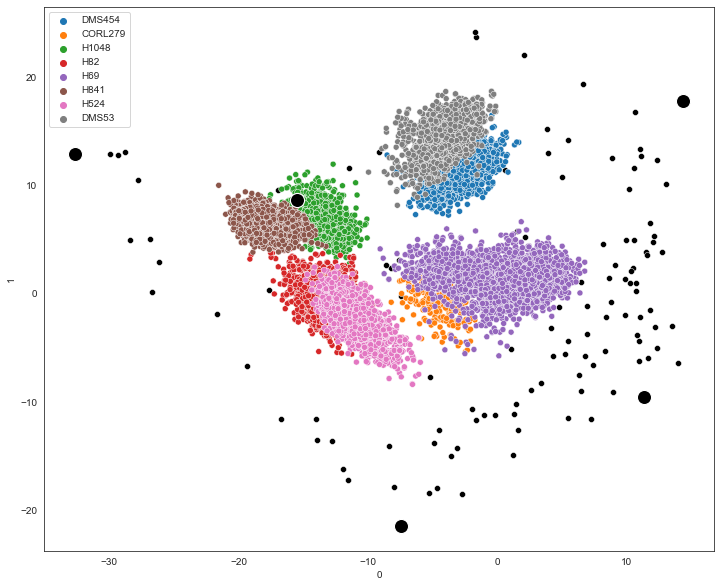

In [426]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'black')
sns.scatterplot(-adata_pca_df_hvgs[0], adata_pca_df_hvgs[1], hue =  X_magic.obs['cline'])
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
plt.savefig('../../figures/adata_pca_hvgs_in_arc_space.pdf')

In [435]:
n_shuffles = 50
adata_var_dict_hvgs['shuffled_fit_EV'] = EV_shuffled_fit(shared_genes, adata_df_hvgs, n_shuffles=n_shuffles)
adata_var_dict_hvgs['EV_upperbound'] = pca_upperbound(adata_df_hvgs)

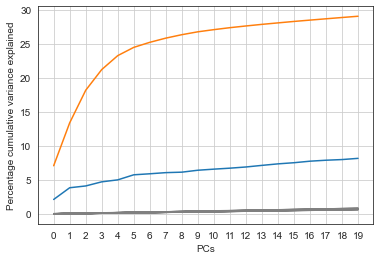

In [436]:
sns.lineplot(range(20),100*(Cumulative(adata_var_dict_hvgs['varexpl'])/adata_var_dict_hvgs['tot_var_full']))
sns.lineplot(range(20),100*(Cumulative(adata_var_dict_hvgs['EV_upperbound'])/adata_var_dict_hvgs['tot_var_full']))
for i in range(n_shuffles):
    plt.plot([100*x for x in Cumulative(adata_var_dict_hvgs['shuffled_fit_EV'][i])/adata_var_dict_hvgs['tot_var_full']], c = 'grey')
plt.xticks(range(20))
plt.grid()
plt.ylabel('Percentage cumulative variance explained')
plt.xlabel('PCs')
plt.savefig('../../figures/adata_pca_hvgs_in_arc_space_EV.pdf')
plt.show()

In [445]:
# Variance explained in single cell data by single cell PCA
100*(Cumulative(adata_var_dict_hvgs['EV_upperbound'])/adata_var_dict_hvgs['tot_var_full'])[6]

25.261246062197788

In [444]:
# Variance explained in single cell data by bulk PCA
100*(Cumulative(adata_var_dict_hvgs['varexpl'])/adata_var_dict_hvgs['tot_var_full'])[6]

5.929192081704409

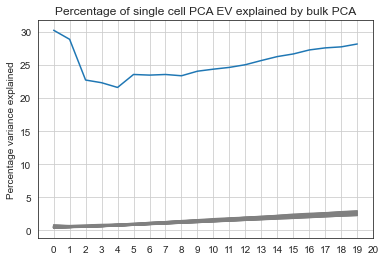

In [437]:
sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['varexpl']),Cumulative(adata_var_dict_hvgs['EV_upperbound']))])
for i in range(n_shuffles):
    sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['shuffled_fit_EV'][i]),Cumulative(adata_var_dict_hvgs['EV_upperbound']))],
                color = 'grey')
plt.xticks(range(21))
plt.grid()
plt.title('Percentage of single cell PCA EV explained by bulk PCA')
plt.ylabel('Percentage variance explained')
plt.savefig('../../figures/adata_pca_hvgs_in_arc_space_EV_of_scEV.pdf')

plt.show()

In [446]:
#EV at 7 PCs
[i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['varexpl']),Cumulative(adata_var_dict_hvgs['EV_upperbound']))][6]

0.2347149490213451

In [457]:
# Average for different numbers of PCs
EV_ratios = [i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['varexpl']),Cumulative(adata_var_dict_hvgs['EV_upperbound']))]
np.average(EV_ratios)

0.25363384424559365

In [460]:
#SEM for EV
n_components = 20
np.std(EV_ratios)/np.sqrt(n_components)

0.005212524951014836

In [472]:
random_ave_expl = []
for q in range(n_shuffles):
    random_ave_expl.append([i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['shuffled_fit_EV'][q]),
                 Cumulative(adata_var_dict_hvgs['EV_upperbound']))][6])


In [473]:
np.average([100*i for i in random_ave_expl])

1.0198244327221637

In [441]:
np.std([100*i for i in random_ave_expl])/np.sqrt(n_shuffles)

0.009816590860618448

### Fit to X_magic

In [447]:
magic_df_hvgs, magic_pca_df_hvgs, magic_var_dict_hvgs = transform_data(X_magic, pca, shared_genes)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


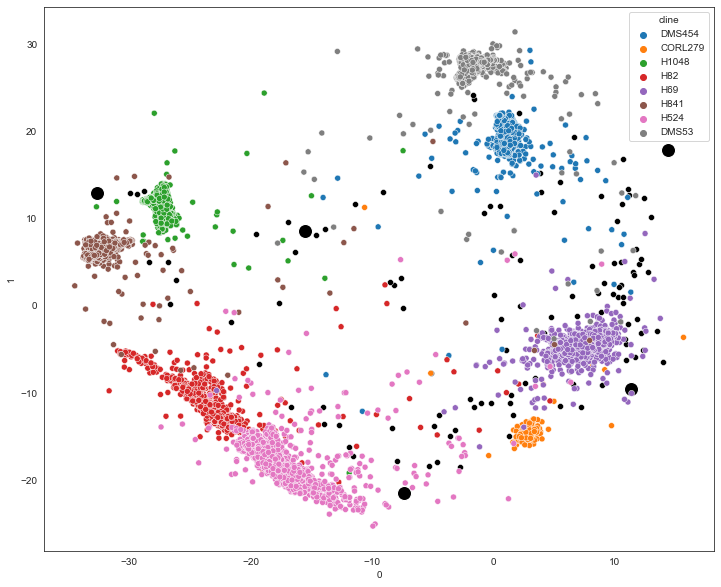

In [448]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'black')
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
sns.scatterplot(-magic_pca_df_hvgs[0], magic_pca_df_hvgs[1], hue =  X_magic.obs['cline'])
plt.savefig('../../figures/magic_pca_hvgs_in_arc_space.pdf')

In [449]:
n_shuffles = 50
magic_var_dict_hvgs['shuffled_fit_EV'] = EV_shuffled_fit(shared_genes, magic_df_hvgs, n_shuffles=n_shuffles)
magic_var_dict_hvgs['EV_upperbound'] = pca_upperbound(magic_df_hvgs)

In [450]:
magic_var_dict['tot_var_full']

12135.326

In [451]:
magic_var_dict_hvgs['tot_var_full']

2483.986

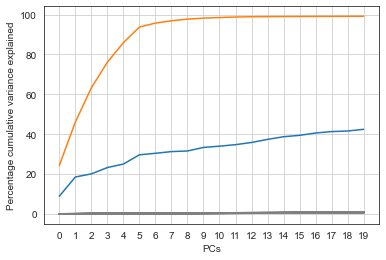

In [452]:
plt.figure(figsize = (6,4))
sns.lineplot(range(20),100*(Cumulative(magic_var_dict_hvgs['varexpl'])/magic_var_dict_hvgs['tot_var_full']))
sns.lineplot(range(20),100*(Cumulative(magic_var_dict_hvgs['EV_upperbound'])/magic_var_dict_hvgs['tot_var_full']))
for i in range(n_shuffles):
    plt.plot([100*x for x in Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][i])/magic_var_dict_hvgs['tot_var_full']], c = 'grey')
plt.xticks(range(20))
plt.grid()
plt.ylabel('Percentage cumulative variance explained')
plt.xlabel('PCs')
plt.savefig('../../figures/magic_pca_hvgs_in_arc_space_EV.pdf')

plt.show()


"We computed the fraction of variance in gene expression explained by principal components computed on gene expression of metabric tumors. This fraction is necessarily bounded by the fraction of variance explained by principal components computed on gene expression from single cells. In other words, if intratumor heterogeneity and intertumor diversity were perfectly aligned in gene expression space, the fraction of variance explained by metabric principal components would equal the fraction of variance explained by single-cell principal components."

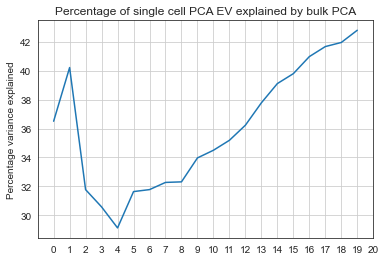

In [453]:
sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['varexpl']),Cumulative(magic_var_dict_hvgs['EV_upperbound']))])
plt.xticks(range(21))
plt.grid()
plt.title('Percentage of single cell PCA EV explained by bulk PCA')
plt.ylabel('Percentage variance explained')
plt.show()

In [465]:
# Average for different numbers of PCs
EV_ratios = [i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['varexpl']),Cumulative(magic_var_dict_hvgs['EV_upperbound']))]
np.average(EV_ratios)

0.3600841133745868

In [470]:
EV_ratios[6]

0.3177271080610284

In [466]:
#SEM for EV
n_components = 20
np.std(EV_ratios)/np.sqrt(n_components)

0.009358536006481497

In [474]:
random_ave_expl = []
for q in range(n_shuffles):
    random_ave_expl.append([i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][q]),
                 Cumulative(magic_var_dict_hvgs['EV_upperbound']))][6])


In [475]:
np.average([100*i for i in random_ave_expl])

0.26211027859230956

In [476]:
np.std([100*i for i in random_ave_expl])/np.sqrt(n_shuffles)

0.008317007428745093

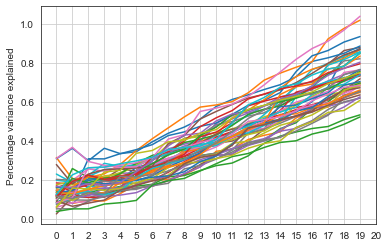

In [461]:
for i in range(n_shuffles):
    sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][i]),Cumulative(magic_var_dict_hvgs['EV_upperbound']))])
plt.xticks(range(21))
plt.grid()
plt.ylabel('Percentage variance explained')

plt.show()

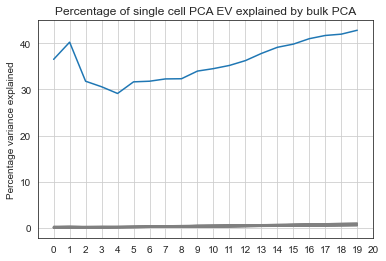

In [462]:
sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['varexpl']),Cumulative(magic_var_dict_hvgs['EV_upperbound']))])
for i in range(n_shuffles):
    sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][i]),Cumulative(magic_var_dict_hvgs['EV_upperbound']))],
                color = 'grey')
plt.xticks(range(21))
plt.grid()
plt.title('Percentage of single cell PCA EV explained by bulk PCA')
plt.ylabel('Percentage variance explained')
plt.savefig('../../figures/magic_pca_hvgs_in_arc_space_EV_of_scEV.pdf')

plt.show()

## Scoring archetype signature genes vs random

In [77]:
sc.tl.score_genes(adata, gene_list=arc.index)

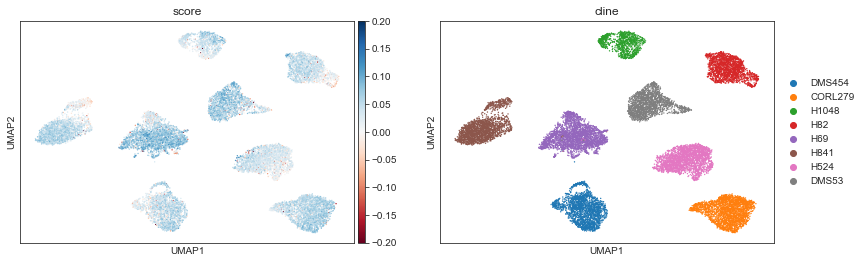

In [82]:
from matplotlib.colors import CenteredNorm 
sc.pl.umap(adata, color=['score', 'cline'], cmap = 'RdBu', vmax=.2, vmin = -.2)

In [148]:
adata.write_h5ad('../../out/cell-lines/adata_no_doublets_02.h5ad')